# TP1: Unsupervised Learning - **2025/2026**
**Student Name:** Atef BOUZID


## Introduction
This notebook contains solutions to TP1 on unsupervised learning, covering:
- Clustering (K-means)
- Density estimation (Gaussian Mixture Models)
- Dimensionality reduction (PCA, NMF, t-SNE)


## 0. Importing Libraries

In [2]:
import numpy as np
import pylab as pl
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import rand_score, adjusted_rand_score, pairwise_distances_argmin_min
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## 1. Loading the Data

In [3]:
temper_data = np.load('temper.npz')
x1 = temper_data['data'][:, :12]  # Extract only the first 12 columns (temperature data)
villes = temper_data['villes']  # City names
coordinates =temper_data['data'][:, 12:]
varname = temper_data['varname']  # Variable names

digits_data = np.load('digits.npz')
x2 = digits_data['x'] / 255.0 
x2_test = digits_data['xt'] / 255.0

### 1.1 Exploratory Data Analysis - Temperature Data

In [4]:
print("Temperature data shape:", x1.shape)
print("Cities:", villes)
print("Variable names:", varname[:12]) 
print("First few temperature values:")
print(x1[:5, :5])
temp_means = np.mean(x1, axis=0)
print("\nMean temperature values for each month:")
for i, month_mean in enumerate(temp_means):
    print(f"Month {i+1}: {month_mean:.2f}")

Temperature data shape: (15, 12)
Cities: ['Bordeaux' 'Brest' 'Clermont-Ferrand' 'Grenoble' 'Lille' 'Lyon'
 'Marseille' 'Montpellier' 'Nantes' 'Nice' 'Paris' 'Rennes' 'Strasbourg'
 'Toulouse' 'Vichy']
Variable names: ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
First few temperature values:
[[ 5.6  6.6 10.3 12.8 15.8]
 [ 6.1  5.8  7.8  9.2 11.6]
 [ 2.6  3.7  7.5 10.3 13.8]
 [ 1.5  3.2  7.7 10.6 14.5]
 [ 2.4  2.9  6.   8.9 12.4]]

Mean temperature values for each month:
Month 1: 3.97
Month 2: 4.83
Month 3: 8.23
Month 4: 10.98
Month 5: 14.43
Month 6: 17.83
Month 7: 19.83
Month 8: 19.57
Month 9: 16.99
Month 10: 12.32
Month 11: 7.93
Month 12: 4.85


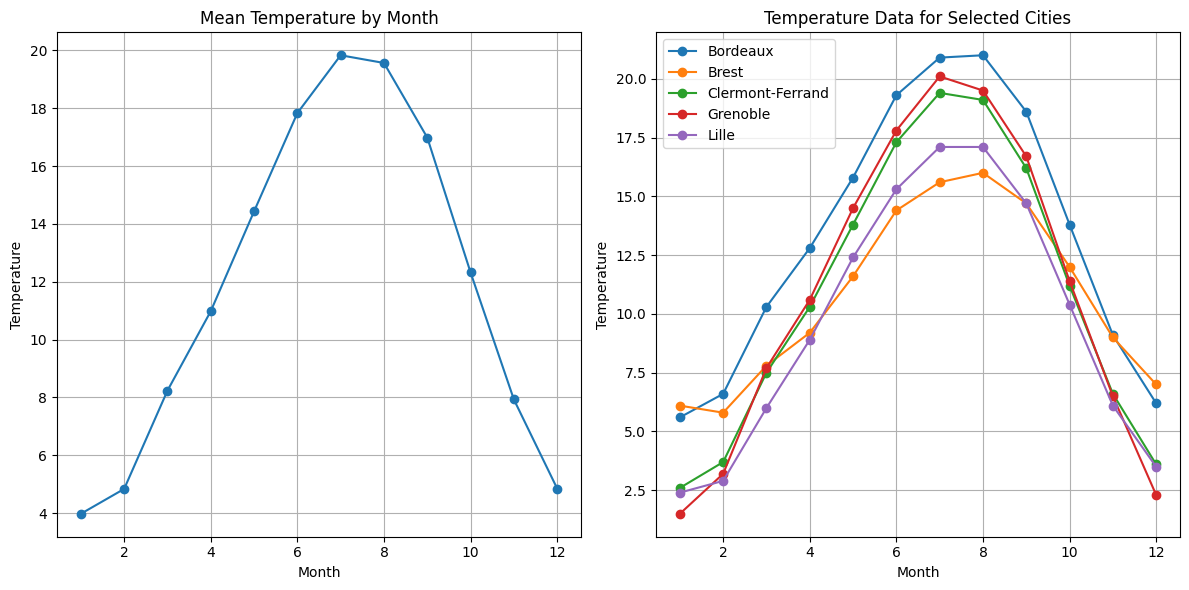

In [5]:
pl.figure(figsize=(12, 6))
pl.subplot(1, 2, 1)
pl.plot(range(1, 13), temp_means, 'o-')
pl.title('Mean Temperature by Month')
pl.xlabel('Month')
pl.ylabel('Temperature')
pl.grid(True)

pl.subplot(1, 2, 2)
for i in range(min(5, len(villes))):
    pl.plot(range(1, 13), x1[i, :], 'o-', label=villes[i])
pl.title('Temperature Data for Selected Cities')
pl.xlabel('Month')
pl.ylabel('Temperature')
pl.legend()
pl.grid(True)
pl.tight_layout()
pl.show()

### 1.2 Exploratory Data Analysis - Digits Data


Digits data shape: (3000, 784)
Digits test data shape: (1500, 784)
Training labels shape: (3000, 1)
Test labels shape: (1500, 1)
Unique digits in training set: [1 7 8]
Unique digits in test set: [1 7 8]


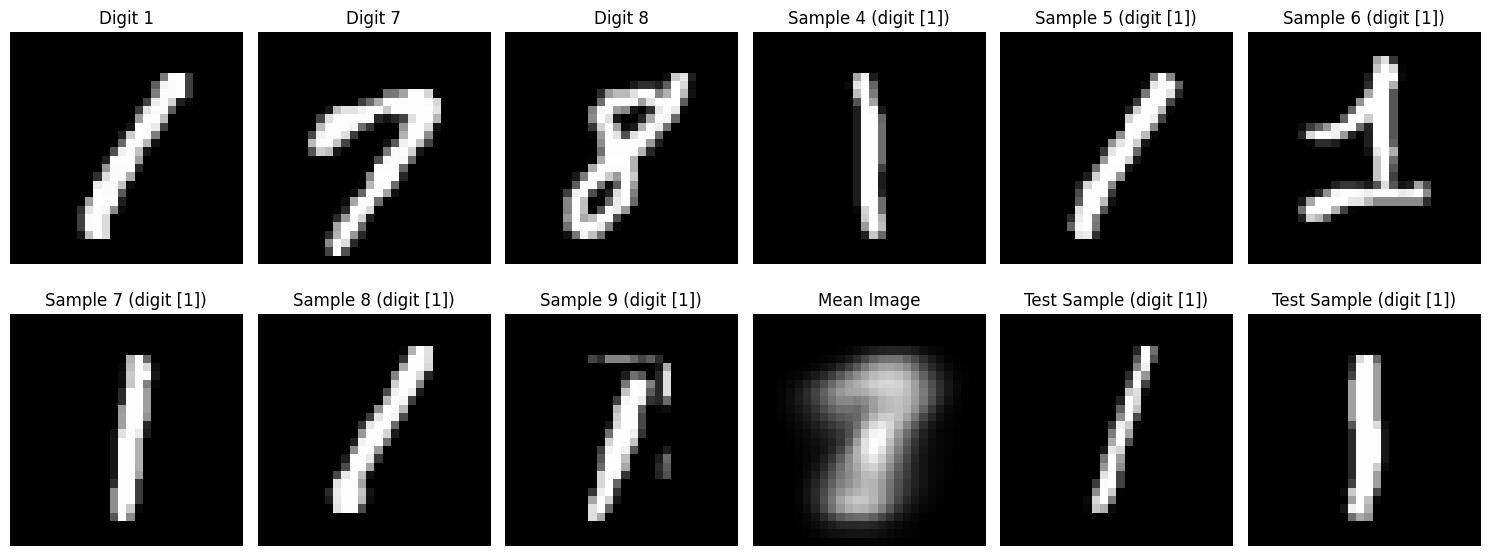

In [6]:
print("Digits data shape:", x2.shape)
print("Digits test data shape:", x2_test.shape)

y2 = digits_data['y']  # Training labels
y2_test = digits_data['yt']  # Test labels

print("Training labels shape:", y2.shape)
print("Test labels shape:", y2_test.shape)
print("Unique digits in training set:", np.unique(y2))
print("Unique digits in test set:", np.unique(y2_test))

digits_mean = np.mean(x2, axis=0)

pl.figure(figsize=(15, 6))

unique_digits = np.unique(y2)
for i, digit in enumerate(unique_digits):
    # Find first occurrence of each digit
    digit_idx = np.where(y2 == digit)[0][0]
    pl.subplot(2, 6, i+1)
    pl.imshow(x2[digit_idx].reshape(28, 28), cmap='gray')
    pl.title(f'Digit {digit}')
    pl.axis('off')

# Show a few more examples
for i in range(3, 9):
    pl.subplot(2, 6, i+1)
    pl.imshow(x2[i].reshape(28, 28), cmap='gray')
    pl.title(f'Sample {i+1} (digit {y2[i]})')
    pl.axis('off')

pl.subplot(2, 6, 10)
pl.imshow(digits_mean.reshape(28, 28), cmap='gray')
pl.title('Mean Image')
pl.axis('off')

pl.subplot(2, 6, 11)
pl.imshow(x2_test[0].reshape(28, 28), cmap='gray')
pl.title(f'Test Sample (digit {y2_test[0]})')
pl.axis('off')

pl.subplot(2, 6, 12)
pl.imshow(x2_test[10].reshape(28, 28), cmap='gray')
pl.title(f'Test Sample (digit {y2_test[10]})')
pl.axis('off')

pl.tight_layout()
pl.show()


## 2. Clustering with K-means

### 2.1 Question 1: Apply K-means (K = 3) on both datasets

In [7]:
RANDOM_STATE = 42

# Temperature dataset
k_temp = 3
kmeans_temp = KMeans(n_clusters=k_temp, n_init=10, random_state=RANDOM_STATE)
temp_labels = kmeans_temp.fit_predict(x1)
temp_centroids = kmeans_temp.cluster_centers_

# Digits dataset
k_digits = 3
kmeans_digits = KMeans(n_clusters=k_digits, n_init=10, random_state=RANDOM_STATE)
digits_labels = kmeans_digits.fit_predict(x2)
digits_centroids = kmeans_digits.cluster_centers_

#### Temperature Dataset Results

Cluster 0 (7 cities): Clermont-Ferrand, Grenoble, Lille, Lyon, Paris, Strasbourg, Vichy
Cluster 1 (5 cities): Bordeaux, Marseille, Montpellier, Nice, Toulouse
Cluster 2 (3 cities): Brest, Nantes, Rennes


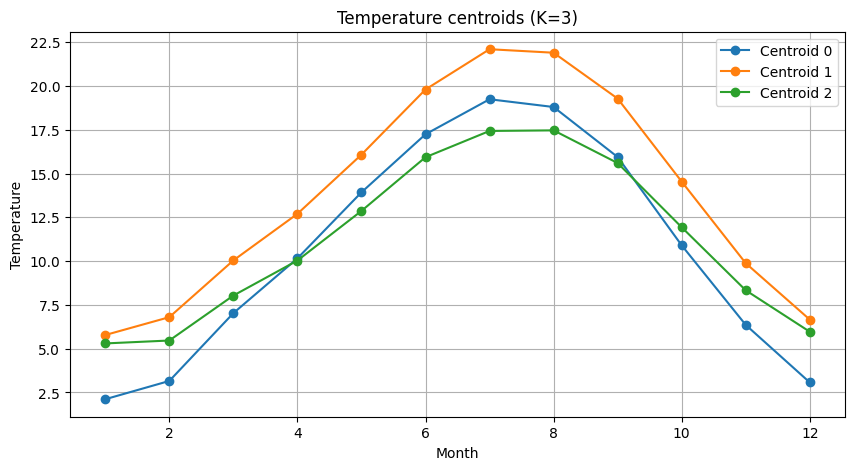

In [8]:
# list cities per cluster
clusters_to_cities = {c: [] for c in range(k_temp)}
for idx, lab in enumerate(temp_labels):
    clusters_to_cities[lab].append(villes[idx])

for c in range(k_temp):
    print(f"Cluster {c} ({len(clusters_to_cities[c])} cities): {', '.join(clusters_to_cities[c])}")

months = [str(m) for m in range(1, 13)]

pl.figure(figsize=(10, 5))
for c in range(k_temp):
    pl.plot(range(1, 13), temp_centroids[c], 'o-', label=f'Centroid {c}')
pl.title('Temperature centroids (K=3)')
pl.xlabel('Month')
pl.ylabel('Temperature')
pl.legend()
pl.grid(True)
pl.show()

#### Geographical Visualization of Clusters

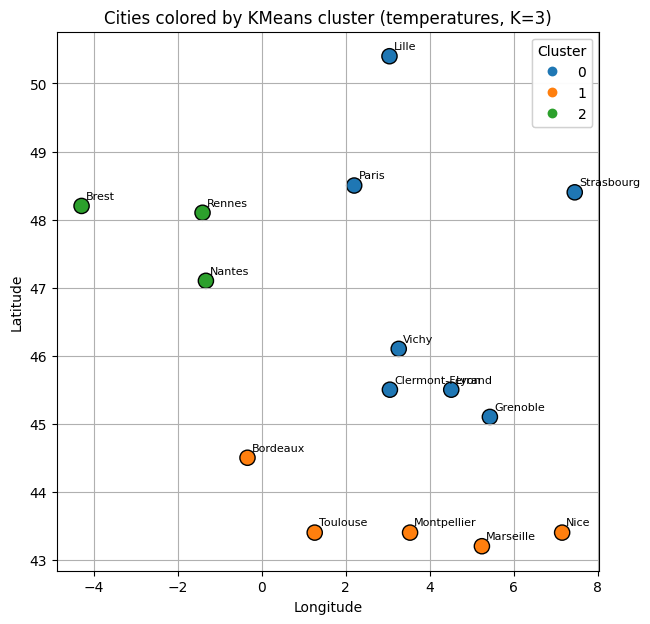

In [9]:
lats, lons, colors = [], [], []
for i, city in enumerate(villes):
    lat, lon = coordinates[i]
    lats.append(lat)
    lons.append(lon)
    colors.append(temp_labels[i])

pl.figure(figsize=(7, 7))
scatter = pl.scatter(lons, lats, c=colors, cmap='tab10', s=120, edgecolor='k',vmax=9)
for i, city in enumerate(villes):
    pl.text(lons[i] + 0.1, lats[i] + 0.1, str(city), fontsize=8)
pl.xlabel('Longitude')
pl.ylabel('Latitude')
pl.title('Cities colored by KMeans cluster (temperatures, K=3)')
legend1 = pl.legend(*scatter.legend_elements(), title="Cluster")
pl.gca().add_artist(legend1)
pl.grid(True)
pl.show()

### 2.2 Question 2: Interpretation of Temperature Clustering Results

> **Analysis of city clusters:**
> 
> **Cluster 0 (7 cities): Clermont-Ferrand, Grenoble, Lille, Lyon, Paris, Strasbourg, Vichy**
> - These cities are mostly located in continental/inland France with more continental climate patterns
> - They experience colder winters and more temperature variation throughout the year
> 
> **Cluster 1 (5 cities): Bordeaux, Marseille, Montpellier, Nice, Toulouse**
> - These cities are located in southern France along the Mediterranean coast and Atlantic southwest
> - They have warmer, more Mediterranean climate with milder winters and hot summers
> 
> **Cluster 2 (3 cities): Brest, Nantes, Rennes**
> - These cities are all located in western France (Brittany region)
> - They experience oceanic climate with mild temperatures year-round due to maritime influence
> 
> **Conclusion:** The clustering groups cities with similar temperature patterns based on their geographical location and climate zones. The K-means clustering makes geographical and climatological sense, successfully identifying three distinct climate regions in France.

#### Digits Dataset Results

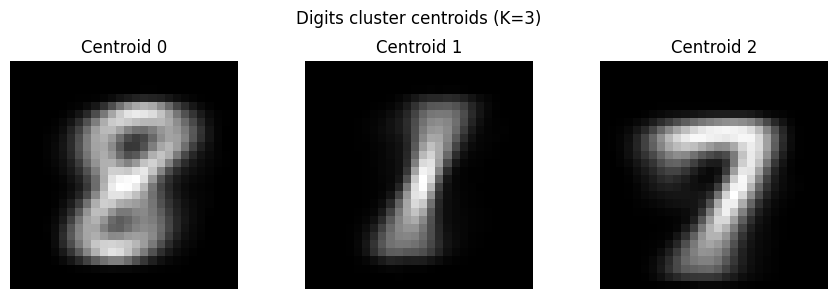

In [10]:
pl.figure(figsize=(9, 3))
for c in range(k_digits):
    pl.subplot(1, k_digits, c+1)
    pl.imshow(digits_centroids[c].reshape(28, 28), cmap='gray')
    pl.title(f'Centroid {c}')
    pl.axis('off')
pl.suptitle('Digits cluster centroids (K=3)')
pl.tight_layout()
pl.show()

### 2.3 Digits Dataset Analysis

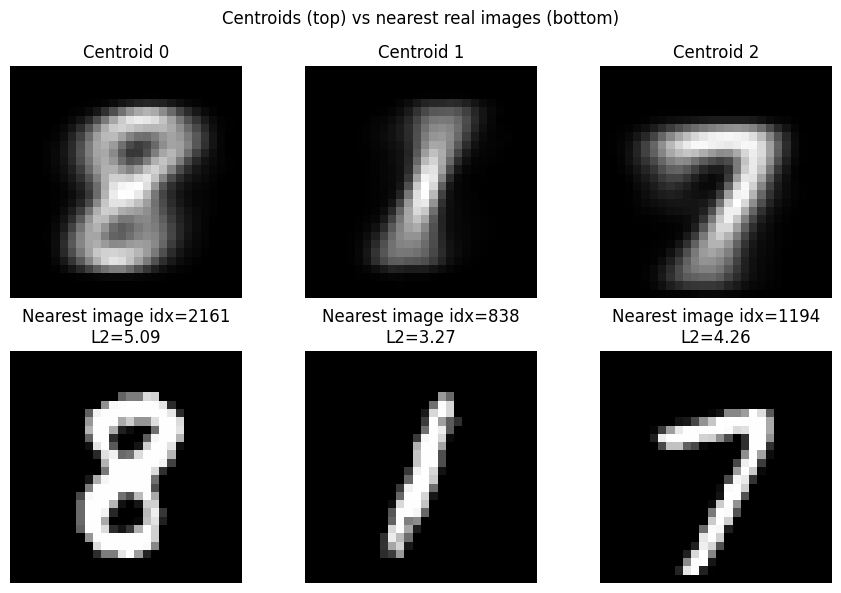

In [11]:
# Find nearest training image to each centroid
nearest_idx, nearest_dist = pairwise_distances_argmin_min(digits_centroids, x2)

pl.figure(figsize=(3*k_digits, 6))
for c in range(k_digits):
    pl.subplot(2, k_digits, c+1)
    pl.imshow(digits_centroids[c].reshape(28, 28), cmap='gray')
    pl.title(f'Centroid {c}')
    pl.axis('off')

    pl.subplot(2, k_digits, k_digits + c + 1)
    pl.imshow(x2[nearest_idx[c]].reshape(28, 28), cmap='gray')
    title = f'Nearest image idx={nearest_idx[c]}\nL2={nearest_dist[c]:.2f}'
    pl.title(title)
    pl.axis('off')

pl.suptitle('Centroids (top) vs nearest real images (bottom)')
pl.tight_layout()
pl.show()

#### Question 2.3.1: Are centroids true images?

> **Answer:** Centroids are averages of multiple images and rarely match any single real image (even in our case it seems like they do). Nearest real images are sharper and show actual digits, while **centroids look blurred because they represent the mean of many different digit patterns**. Therefore, they are not true images but rather mathematical constructs representing the average characteristics of a cluster.

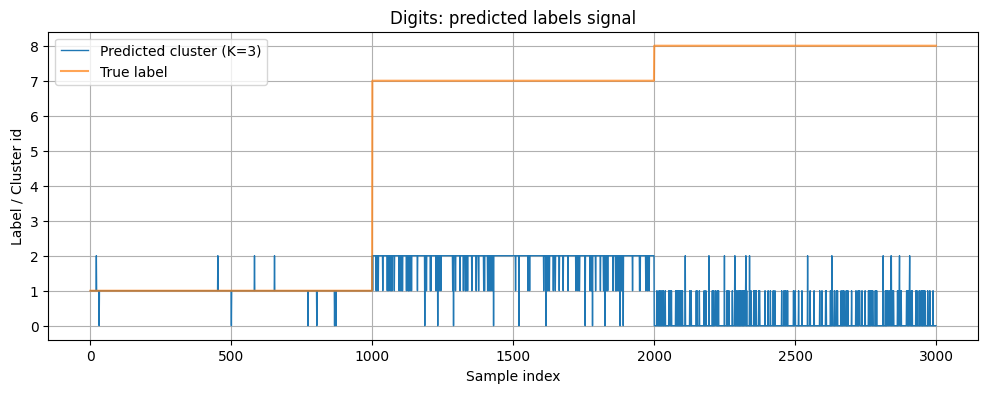

In [12]:
pl.figure(figsize=(12, 4))
pl.plot(digits_labels, label='Predicted cluster (K=3)', linewidth=1)
pl.plot(y2, label='True label', alpha=0.7)
pl.title('Digits: predicted labels signal')
pl.xlabel('Sample index')
pl.ylabel('Label / Cluster id')
pl.legend()
pl.grid(True)
pl.show()

#### Question 2.3.2: What can you observe?

> **Answer:** The predicted labels are not perfectly piecewise constant, deviations from constancy indicate that clusters are mixing multiple digit classes or there are class transitions in the ordering. This suggests that K-means with K=3 cannot perfectly separate the three digit classes (1, 7, 8), as there is overlap in the feature space.

#### Question 2.3.3: Compute Rand score and Adjusted Rand score


In [13]:
rs = rand_score(y2.ravel(), digits_labels)
ars = adjusted_rand_score(y2.ravel(), digits_labels)
print(f'Rand score = {rs:.4f}, Adjusted Rand score = {ars:.4f}')

Rand score = 0.8812, Adjusted Rand score = 0.7345


#### Question 2.3.4: Vary K from 1 to 10 and plot clustering scores


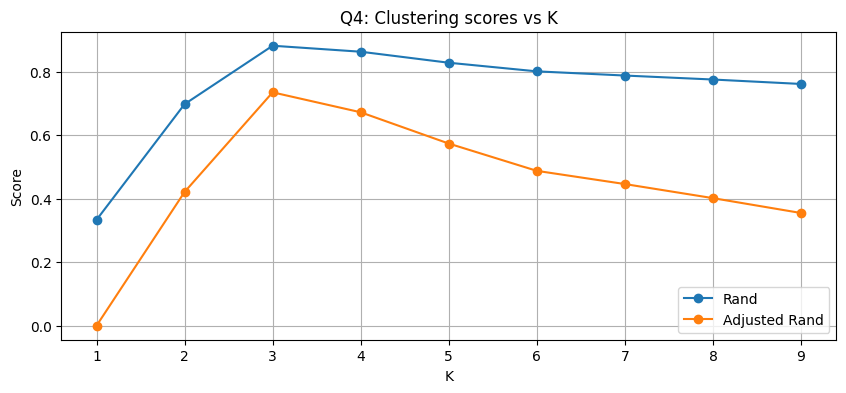

Best K by Adjusted Rand = 3 with score 0.7345.


In [14]:
Ks = list(range(1, 10))
rand_scores = []
adj_rand_scores = []

for K in Ks:
    km = KMeans(n_clusters=K, n_init=10, random_state=RANDOM_STATE)
    labs = km.fit_predict(x2)
    rand_scores.append(rand_score(y2.ravel(), labs))
    adj_rand_scores.append(adjusted_rand_score(y2.ravel(), labs))

pl.figure(figsize=(10, 4))
pl.plot(Ks, rand_scores, 'o-', label='Rand')
pl.plot(Ks, adj_rand_scores, 'o-', label='Adjusted Rand')
pl.xticks(Ks)
pl.xlabel('K')
pl.ylabel('Score')
pl.title('Q4: Clustering scores vs K')
pl.grid(True)
pl.legend()
pl.show()


best_idx = int(np.nanargmax(adj_rand_scores))
best_K = Ks[best_idx]
print(f'Best K by Adjusted Rand = {best_K} with score {adj_rand_scores[best_idx]:.4f}.')

> The best K is 3 with an Adjusted Rand score of 0.7345. This makes sense because K=3 is close to the true number of classes, allowing clusters to better align with actual digit classes. When K is too small, different digit classes get merged into the same cluster. When K is too large, individual digit classes get split across multiple clusters. Both scenarios reduce the Adjusted Rand Index.


## 3. Density estimation

### 3.1 Fitting GMM to Both Datasets

#### Question 3.1.1: Fit GMM with diagonal covariance (K=2 for temperature, K=3 for digits)


In [15]:
# temperature
K_temp = 2
gmm_temp = GaussianMixture(n_components=K_temp, covariance_type='diag', random_state=RANDOM_STATE)
gmm_temp.fit(x1)

means_temp = gmm_temp.means_  
weights_temp = gmm_temp.weights_

print('Fitted GMM (temperature) with K=2, diag covariance')
print('Weights:', np.round(weights_temp, 3))

# digits
K_dig = 3 
gmm_dig = GaussianMixture(n_components=K_dig, covariance_type="diag", random_state=RANDOM_STATE)
gmm_dig.fit(x2)

means_dig = gmm_dig.means_  
weights_dig = gmm_dig.weights_

print('Fitted GMM (digits) with K=3, diag covariance')
print('Weights:', np.round(weights_dig, 3))

Fitted GMM (temperature) with K=2, diag covariance
Weights: [0.667 0.333]
Fitted GMM (digits) with K=3, diag covariance
Weights: [0.284 0.215 0.501]


#### Question 3.1.2: Plot and interpret the GMM centers

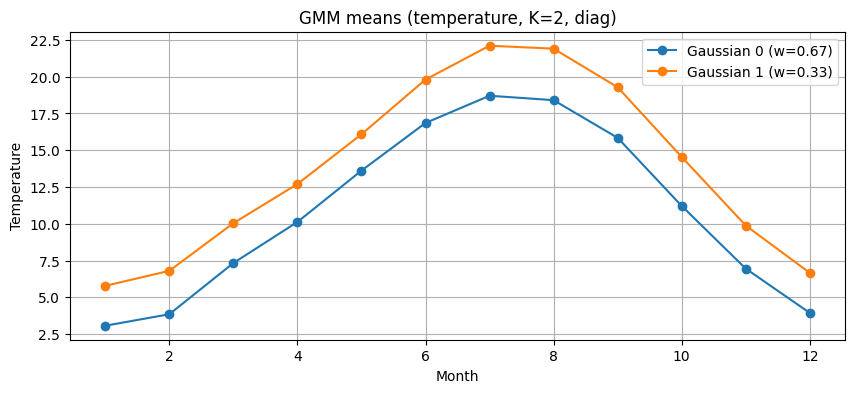

In [16]:
pl.figure(figsize=(10, 4))
for k in range(K_temp):
    pl.plot(range(1, 13), means_temp[k], 'o-', label=f'Gaussian {k} (w={weights_temp[k]:.2f})')
pl.title('GMM means (temperature, K=2, diag)')
pl.xlabel('Month')
pl.ylabel('Temperature')
pl.legend()
pl.grid(True)
pl.show()

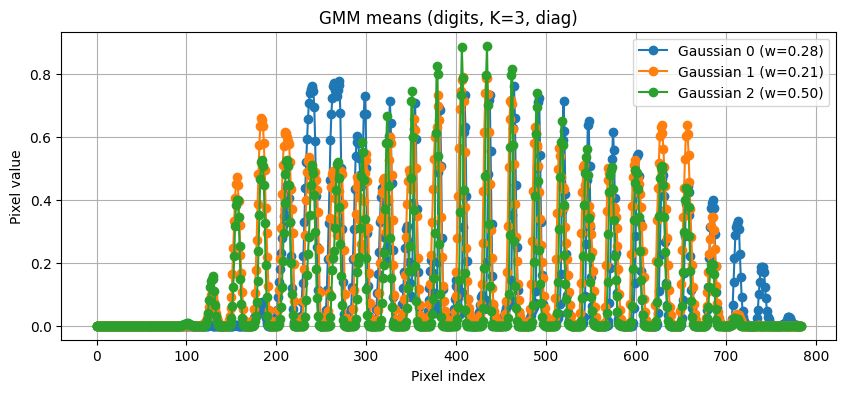

In [17]:
pl.figure(figsize=(10, 4))
for k in range(K_dig):
    pl.plot(means_dig[k], 'o-', label=f'Gaussian {k} (w={weights_dig[k]:.2f})')
pl.title('GMM means (digits, K=3, diag)')
pl.xlabel('Pixel index')
pl.ylabel('Pixel value')
pl.legend()
pl.grid(True)
pl.show()

**Interpretation of GMM Centers:**

**Temperature data (K=2):** 
- The means represent two distinct prototypical annual temperature profiles
- Each Gaussian captures a different seasonal pattern - likely one for warmer regions and one for cooler regions
- The weights (0.667 and 0.333) show how prevalent each temperature pattern is in the dataset
- The component with higher weight represents the more common climate pattern

**Digits data (K=3):** 
- The means represent three prototypical digit patterns in pixel space
- Each Gaussian center shows the average pixel intensities for a cluster of similar-looking digits
- These centers act as "templates" that capture the most common visual features for each group of digits
- The weights indicate the proportion of samples belonging to each component

#### Question 3.1.3: Model selection using BIC and AIC

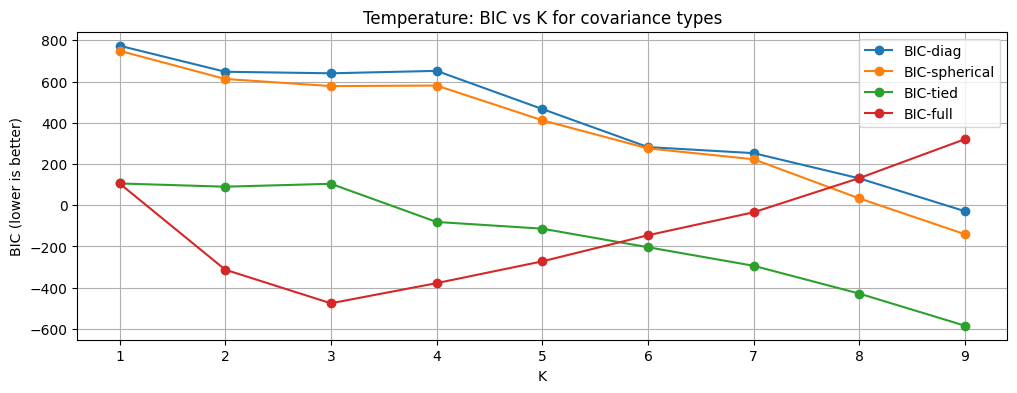

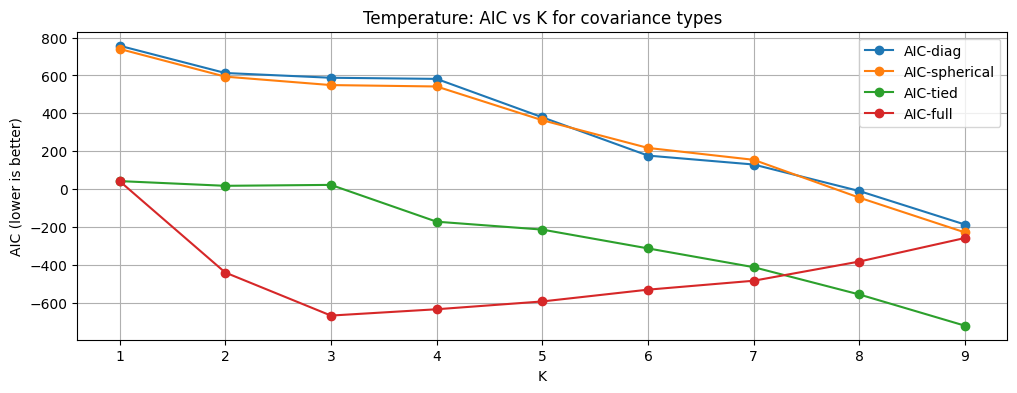

Best by BIC: cov=tied, K=9, BIC=-584.7


In [18]:
cov_types = ['diag', 'spherical', 'tied', 'full']
Ks = list(range(1, 10))

bic_table = {cov: [] for cov in cov_types}
aic_table = {cov: [] for cov in cov_types}

for cov in cov_types:
    for K in Ks:
        gm = GaussianMixture(n_components=K, covariance_type=cov, random_state=RANDOM_STATE)
        gm.fit(x1)
        bic_table[cov].append(gm.bic(x1))
        aic_table[cov].append(gm.aic(x1))

pl.figure(figsize=(12, 4))
for cov in cov_types:
    pl.plot(Ks, bic_table[cov], 'o-', label=f'BIC-{cov}')
pl.title('Temperature: BIC vs K for covariance types')
pl.xlabel('K')
pl.ylabel('BIC (lower is better)')
pl.legend(); pl.grid(True); pl.show()

pl.figure(figsize=(12, 4))
for cov in cov_types:
    pl.plot(Ks, aic_table[cov], 'o-', label=f'AIC-{cov}')
pl.title('Temperature: AIC vs K for covariance types')
pl.xlabel('K')
pl.ylabel('AIC (lower is better)')
pl.legend(); pl.grid(True); pl.show()

best_cov, best_K, best_bic = None, None, np.inf
for cov in cov_types:
    K_idx = int(np.argmin(bic_table[cov]))
    if bic_table[cov][K_idx] < best_bic:
        best_bic = bic_table[cov][K_idx]
        best_cov = cov
        best_K = Ks[K_idx]
print(f'Best by BIC: cov={best_cov}, K={best_K}, BIC={best_bic:.1f}')

**Note:** Lower BIC/AIC indicates a better trade-off between model fit and complexity. BIC penalizes model complexity more heavily than AIC.

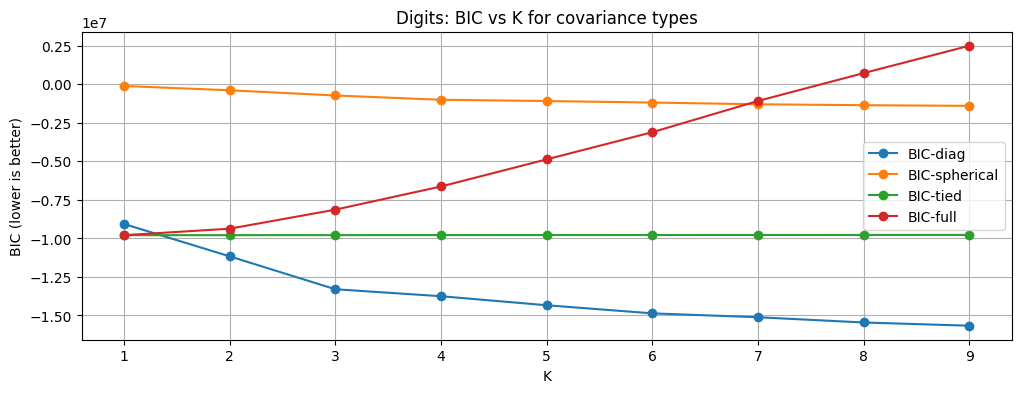

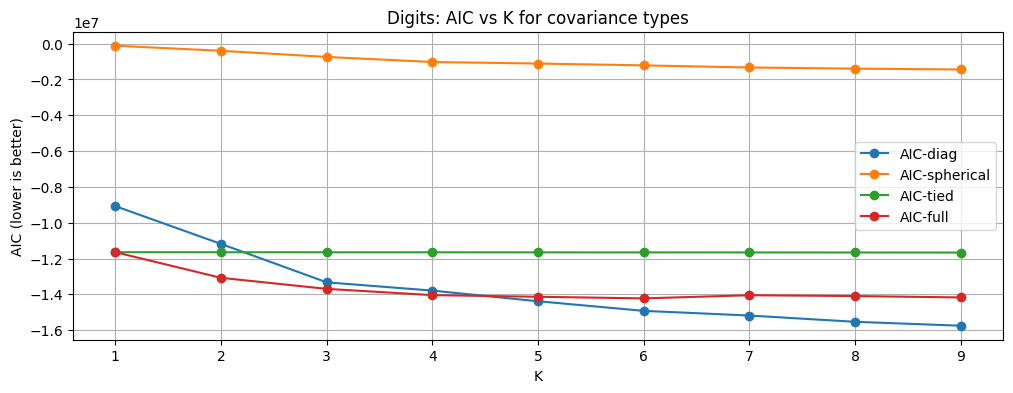

Best by BIC: cov=diag, K=9, BIC=-15667726.5


In [19]:
cov_types = ['diag', 'spherical', 'tied', 'full']
Ks = list(range(1, 10))

bic_table = {cov: [] for cov in cov_types}
aic_table = {cov: [] for cov in cov_types}

for cov in cov_types:
    for K in Ks:
        gm = GaussianMixture(n_components=K, covariance_type=cov, random_state=RANDOM_STATE)
        gm.fit(x2)
        bic_table[cov].append(gm.bic(x2))
        aic_table[cov].append(gm.aic(x2))

pl.figure(figsize=(12, 4))
for cov in cov_types:
    pl.plot(Ks, bic_table[cov], 'o-', label=f'BIC-{cov}')
pl.title('Digits: BIC vs K for covariance types')
pl.xlabel('K')
pl.ylabel('BIC (lower is better)')
pl.legend(); pl.grid(True); pl.show()

pl.figure(figsize=(12, 4))
for cov in cov_types:
    pl.plot(Ks, aic_table[cov], 'o-', label=f'AIC-{cov}')
pl.title('Digits: AIC vs K for covariance types')
pl.xlabel('K')
pl.ylabel('AIC (lower is better)')
pl.legend(); pl.grid(True); pl.show()

best_cov, best_K, best_bic = None, None, np.inf
for cov in cov_types:
    K_idx = int(np.argmin(bic_table[cov]))
    if bic_table[cov][K_idx] < best_bic:
        best_bic = bic_table[cov][K_idx]
        best_cov = cov
        best_K = Ks[K_idx]
print(f'Best by BIC: cov={best_cov}, K={best_K}, BIC={best_bic:.1f}')

#### Question 3.1.4: Detect outliers using log-probability

Least probable (outlier) cities:
- Brest: logp=-30.662
- Strasbourg: logp=-23.881
- Toulouse: logp=-21.491
- Lille: logp=-20.625
- Nice: logp=-20.240


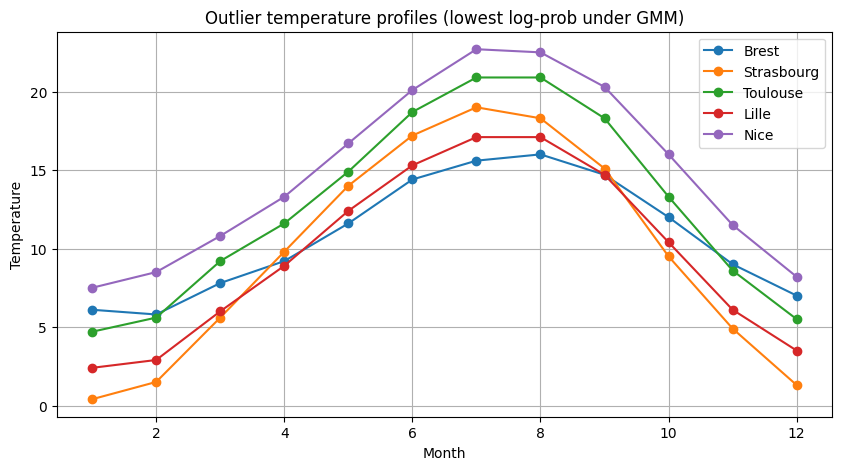

In [20]:
log_probs = gmm_temp.score_samples(x1)
num_outliers = min(5, len(log_probs))
outlier_idx = np.argsort(log_probs)[:num_outliers]

print('Least probable (outlier) cities:')
for idx in outlier_idx:
    print(f'- {villes[idx]}: logp={log_probs[idx]:.3f}')

pl.figure(figsize=(10, 5))
for idx in outlier_idx:
    pl.plot(range(1, 13), x1[idx], 'o-', label=f'{villes[idx]}')
pl.title('Outlier temperature profiles (lowest log-prob under GMM)')
pl.xlabel('Month')
pl.ylabel('Temperature')
pl.legend()
pl.grid(True)
pl.show()

> **Interpretation:** 
> - These cities have the lowest log-probability under the fitted GMM, indicating they are outliers
> - They exhibit unusual seasonal patterns or extreme temperature profiles that don't fit well with the main patterns
> - Brest has the lowest likelihood, suggesting its oceanic climate is most different from the typical patterns
> - These outliers represent atypical climate behaviors within the French city dataset

#### Question 3.1.5: Compare GMM with K-means clustering


In [21]:
gmm_labels = gmm_dig.predict(x2)
gmm_rand_score = adjusted_rand_score(y2.ravel(), gmm_labels)

# K-means clustering (K=3 to match GMM)
kmeans_comp = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
kmeans_labels_comp = kmeans_comp.fit_predict(x2)
kmeans_rand_score = adjusted_rand_score(y2.ravel(), kmeans_labels_comp)

print(f'GMM Adjusted Rand Score: {gmm_rand_score:.4f}')
print(f'K-means Adjusted Rand Score: {kmeans_rand_score:.4f}')

GMM Adjusted Rand Score: 0.4802
K-means Adjusted Rand Score: 0.7345


> **GMM is worse than K-means**

> GMM performs differently than K-means for several reasons:
> - **Model assumptions**: GMM models clusters as Gaussian distributions with different shapes and orientations, while K-means assumes spherical clusters of equal size
> - **Soft vs hard clustering**: GMM provides probabilistic cluster assignments, while K-means makes hard assignments
> - **Flexibility**: GMM can handle overlapping clusters and clusters of different sizes/shapes better
> - **Data fit**: Performance depends on whether the data follows Gaussian mixture distribution assumptions
> - **Convergence**: Both use iterative algorithms (EM for GMM, Lloyd's for K-means) but may converge to different local optima
> 
> The relative performance depends on the structure of the data and whether it better fits the assumptions of one model over the other.


#### Question 3.1.6 [BONUS]: Generate samples from GMM

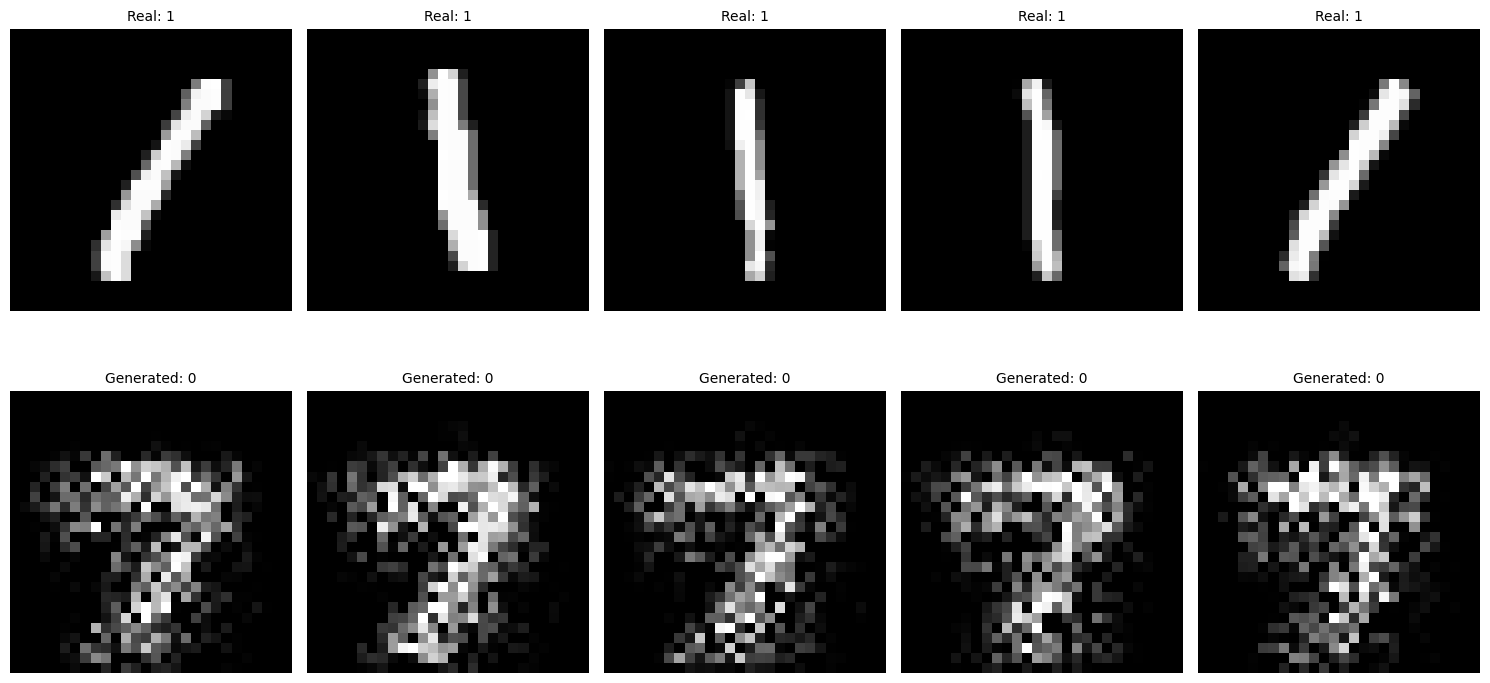

In [22]:
n_samples = 100
generated_samples, generated_labels = gmm_dig.sample(n_samples)

pl.figure(figsize=(15, 8))

# Plot real digits
for i in range(5):
    pl.subplot(2, 5, i+1)
    pl.imshow(x2[i].reshape(28, 28), cmap='gray')
    pl.title(f'Real: {y2[i][0]}', fontsize=10)
    pl.axis('off')

# Plot generated digits
for i in range(5):
    pl.subplot(2, 5, i+6)
    # need to clip values to valid range [0, 1] since original data was normalized
    sample = np.clip(generated_samples[i], 0, 1)
    pl.imshow(sample.reshape(28, 28), cmap='gray')
    pl.title(f'Generated: {generated_labels[i]}', fontsize=10)
    pl.axis('off')

pl.tight_layout()
pl.show()


In [23]:
# Statistical comparison
print(f"Real data - Mean: {x2.mean():.4f}, Std: {x2.std():.4f}")
print(f"Generated - Mean: {generated_samples.mean():.4f}, Std: {generated_samples.std():.4f}")
print(f"Real data range: [{x2.min():.4f}, {x2.max():.4f}]")
print(f"Generated range: [{generated_samples.min():.4f}, {generated_samples.max():.4f}]")

Real data - Mean: 0.1148, Std: 0.2920
Generated - Mean: 0.1184, Std: 0.2946
Real data range: [0.0000, 1.0000]
Generated range: [-1.4007, 2.1314]


In [24]:
# to check if generated samples look realistic
print("Generated samples characteristics:")
print(f"- Mean pixel intensity: {generated_samples.mean():.4f}")
print(f"- Standard deviation: {generated_samples.std():.4f}")
print(f"- Values outside [0,1] range: {np.sum((generated_samples < 0) | (generated_samples > 1))}")

real_mean = x2.mean()
real_std = x2.std()
gen_mean = generated_samples.mean()
gen_std = generated_samples.std()

print(f"\nComparison with real data:")
print(f"- Mean difference: {abs(gen_mean - real_mean):.4f}")
print(f"- Std difference: {abs(gen_std - real_std):.4f}")

Generated samples characteristics:
- Mean pixel intensity: 0.1184
- Standard deviation: 0.2946
- Values outside [0,1] range: 32341

Comparison with real data:
- Mean difference: 0.0036
- Std difference: 0.0026


**Can we differentiate generated samples from real data?**

Yes, we can differentiate generated samples from real data, they are not the same and this because:
- **Visual quality**: Generated samples often appear blurrier than real digits
- **Edge sharpness**: Real digits have clear, well-defined edges and specific stroke patterns
- **Statistical vs structural**: The GMM model captures statistical properties but not the sharp, discrete nature of real handwritten digits
- **Limitations**: A simple Gaussian mixture cannot reproduce the fine-grained structure and sharp transitions present in real handwritten digits
- **Values outside range**: Generated samples may have pixel values outside the valid [0,1] range, requiring clipping

**Conclusion:** While GMM captures the overall statistical distribution, generated samples lack the sharpness and structural details of real handwritten digits.

## 4. Dimensionality Reduction

### 4.1 Linear Projection: Principal Component Analysis (PCA)

#### Question 4.1.1: Compute and visualize covariance matrices

In [25]:
cov_temp = np.cov(x1.T)
print(f"Temperature covariance matrix shape: {cov_temp.shape}")

cov_digits = np.cov(x2.T)
print(f"Digits covariance matrix shape: {cov_digits.shape}")

Temperature covariance matrix shape: (12, 12)
Digits covariance matrix shape: (784, 784)


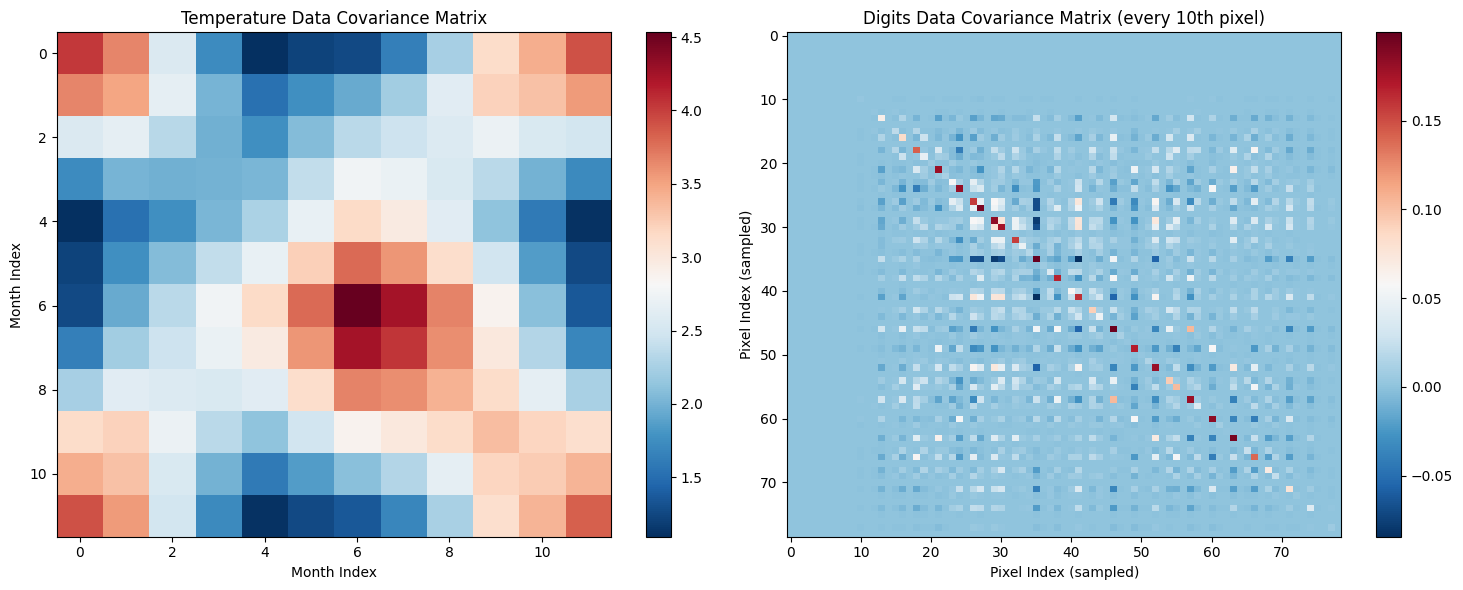

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Temperature covariance
im1 = axes[0].imshow(cov_temp, cmap='RdBu_r', aspect='auto')
axes[0].set_title('Temperature Data Covariance Matrix')
axes[0].set_xlabel('Month Index')
axes[0].set_ylabel('Month Index')
plt.colorbar(im1, ax=axes[0])

# Digits covariance 
# we will take every 10th pixel to make it manageable
sample_indices = np.arange(0, cov_digits.shape[0], 10)
cov_digits_sample = cov_digits[np.ix_(sample_indices, sample_indices)]
im2 = axes[1].imshow(cov_digits_sample, cmap='RdBu_r', aspect='auto')
axes[1].set_title('Digits Data Covariance Matrix (every 10th pixel)')
axes[1].set_xlabel('Pixel Index (sampled)')
axes[1].set_ylabel('Pixel Index (sampled)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

> **Interpretation of Covariance Matrices:**
> 
> **Temperature data:**
> - **Diagonal elements**: Show variance of each month's temperature (how much temperatures vary)
> - **Off-diagonal elements**: Show correlations between months (how temperatures in different months relate)
> 
> what i did notice :
>   - Strong positive correlations between adjacent months (seasonal continuity)
>     - Summer months (6-8) highly correlated with each other
>     - Winter months (12, 1-2) highly correlated with each other
>     - Weaker correlations between summer and winter months
> 
> **Digits data:**
> - **Diagonal elements**: Show variance of each pixel (which pixels vary most across different digits)
> - **Off-diagonal elements**: Show correlations between pixel positions
> 
> what i did notice :
> - Pixels close to each other (spatially) should be more correlated
> - Central pixels typically have higher variance (more informative for digit recognition)
> - Edge pixels may have lower variance (often background)

#### Question 4.1.2: Compute PCA and analyze explained variance

Temperature data - Number of components: 12
Digits data - Number of components: 784


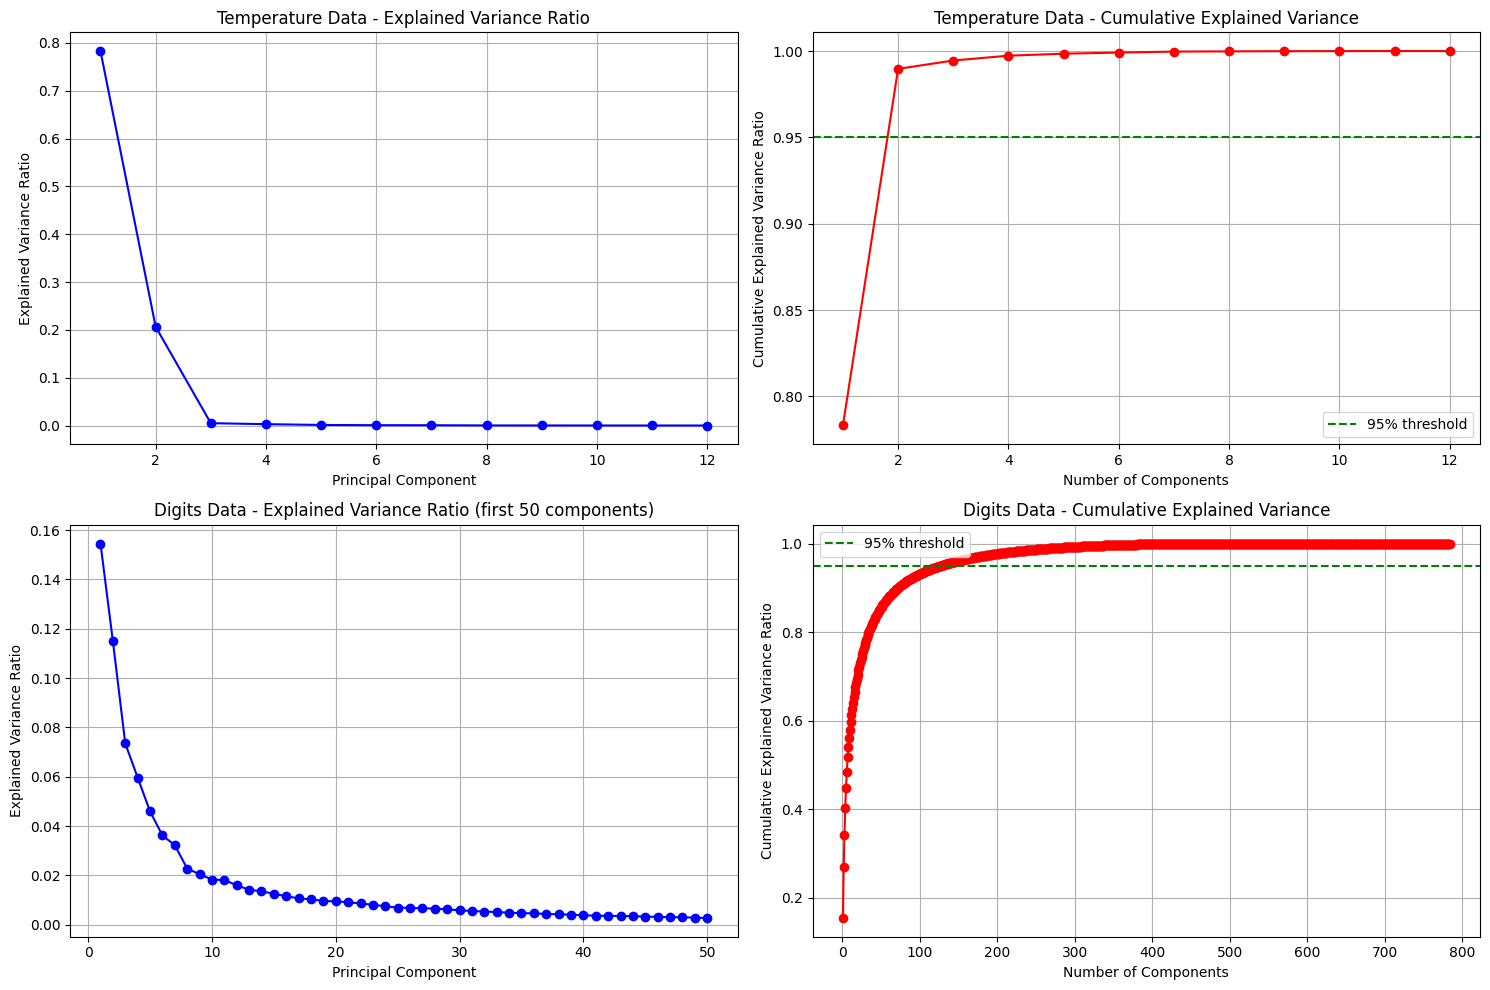

In [27]:
# Fit PCA models (keeping all dimensions)
pca_temp = PCA(n_components=None, random_state=RANDOM_STATE)
pca_temp.fit(x1)

pca_digits = PCA(n_components=None, random_state=RANDOM_STATE)
pca_digits.fit(x2)

# Get explained variance ratios
var_ratio_temp = pca_temp.explained_variance_ratio_
var_ratio_digits = pca_digits.explained_variance_ratio_

print(f"Temperature data - Number of components: {len(var_ratio_temp)}")
print(f"Digits data - Number of components: {len(var_ratio_digits)}")

# Plot explained variance ratios
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Temperature explained variance ratio
axes[0, 0].plot(range(1, len(var_ratio_temp) + 1), var_ratio_temp, 'bo-')
axes[0, 0].set_title('Temperature Data - Explained Variance Ratio')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True)

# Temperature cumulative explained variance
cumsum_temp = np.cumsum(var_ratio_temp)
axes[0, 1].plot(range(1, len(cumsum_temp) + 1), cumsum_temp, 'ro-')
axes[0, 1].set_title('Temperature Data - Cumulative Explained Variance')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance Ratio')
axes[0, 1].grid(True)
axes[0, 1].axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
axes[0, 1].legend()

# Digits explained variance ratio (first 50 components for clarity)
n_show = min(50, len(var_ratio_digits))
axes[1, 0].plot(range(1, n_show + 1), var_ratio_digits[:n_show], 'bo-')
axes[1, 0].set_title('Digits Data - Explained Variance Ratio (first 50 components)')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Explained Variance Ratio')
axes[1, 0].grid(True)

# Digits cumulative explained variance
cumsum_digits = np.cumsum(var_ratio_digits)
axes[1, 1].plot(range(1, len(cumsum_digits) + 1), cumsum_digits, 'ro-')
axes[1, 1].set_title('Digits Data - Cumulative Explained Variance')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Cumulative Explained Variance Ratio')
axes[1, 1].grid(True)
axes[1, 1].axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

> **Answer:**
> 
> **Temperature data:**
> - First 2 components explain ~99.0% of variance
> - Components needed for 95% variance: 2
> 
> ==> Nearly all information can be captured in 2 dimensions
> 
> **Digits data:**
> - First 2 components explain ~27.0% of variance
> - Components needed for 95% variance: 128
> 
> ==> Much higher dimensionality required to preserve information
> 
> **Conclusion:**
> Temperature data has a simple, low-dimensional structure, while digit images require many dimensions to be adequately represented. This difference reflects the inherent complexity: seasonal temperature patterns are simpler than visual patterns in handwritten digits

#### Question 4.1.3 & 4.1.4: Visualize and interpret principal components

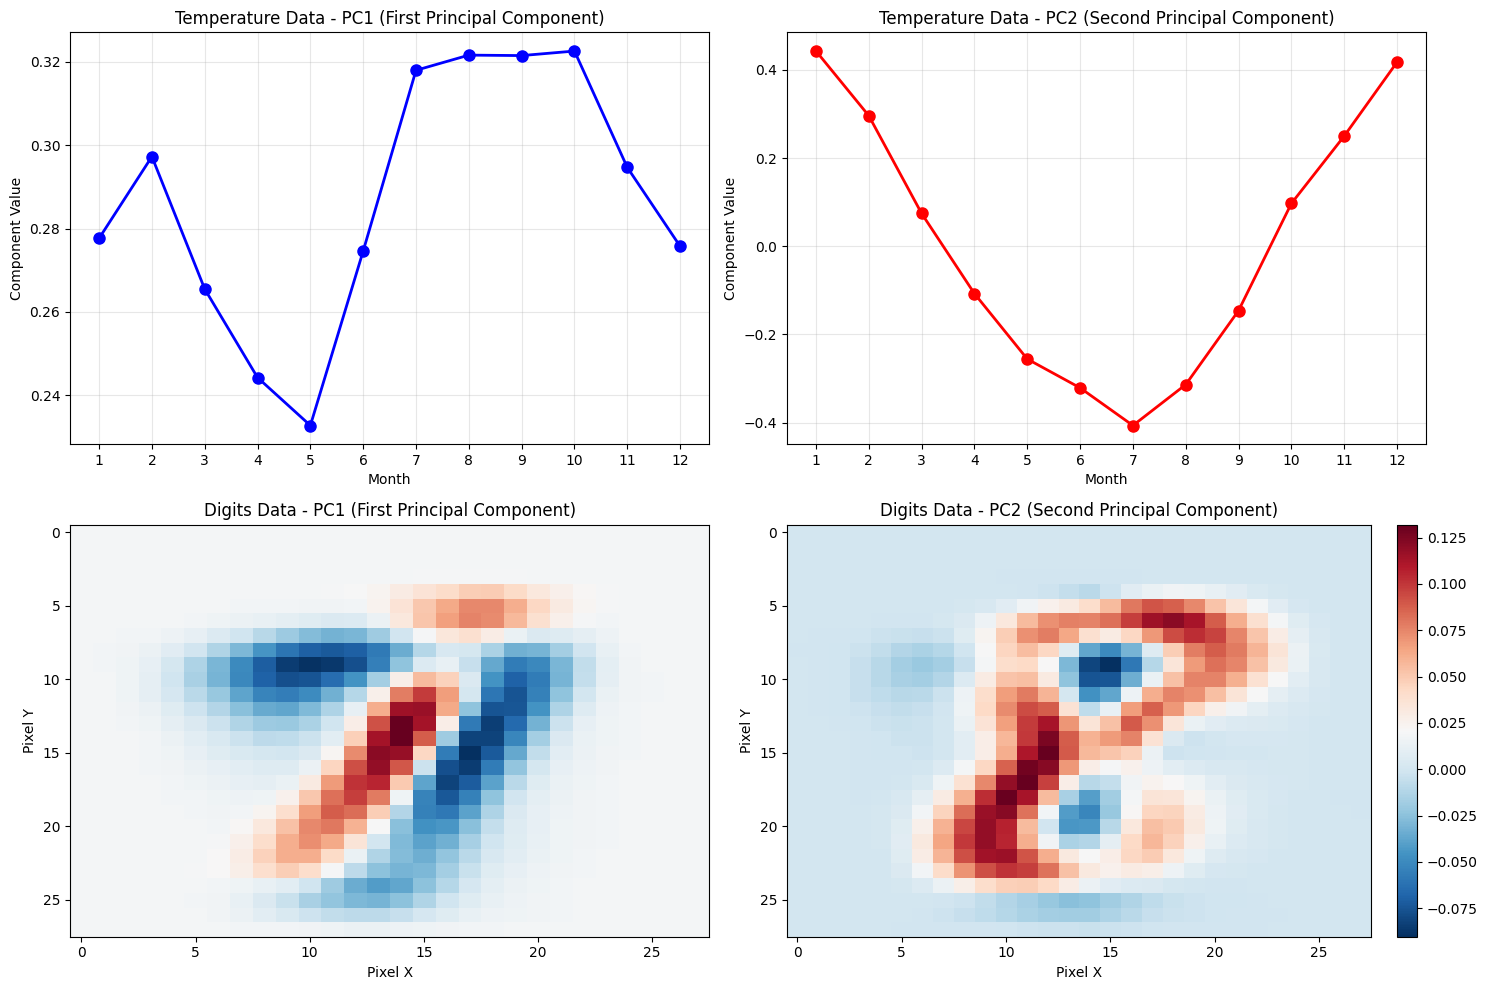

In [28]:
# Get the first two principal components
components_temp = pca_temp.components_[:2]  
components_digits = pca_digits.components_[:2]  

# temperature data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].plot(range(1, 13), components_temp[0], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Temperature Data - PC1 (First Principal Component)')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Component Value')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, 13))

axes[0, 1].plot(range(1, 13), components_temp[1], 'ro-', linewidth=2, markersize=8)
axes[0, 1].set_title('Temperature Data - PC2 (Second Principal Component)')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Component Value')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, 13))


# digits data
axes[1, 0].imshow(components_digits[0].reshape(28, 28), cmap='RdBu_r', aspect='auto')
axes[1, 0].set_title('Digits Data - PC1 (First Principal Component)')
axes[1, 0].set_xlabel('Pixel X')
axes[1, 0].set_ylabel('Pixel Y')

im = axes[1, 1].imshow(components_digits[1].reshape(28, 28), cmap='RdBu_r', aspect='auto')
axes[1, 1].set_title('Digits Data - PC2 (Second Principal Component)')
axes[1, 1].set_xlabel('Pixel X')
axes[1, 1].set_ylabel('Pixel Y')
plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

> **What do these principal components mean?**
> 
> **For temperature data:**
>  The first principal component (PC1) shows us the main pattern in how temperatures change throughout the year. It basically captures the difference between winter and summer months. When we look at the graph, we can see which months are typically warmer or cooler. The second principal component (PC2) picks up on smaller patterns that PC1 missed, like unusual weather variations or differences between regions.
>  
>  **For digit images:**
>  The first principal component (PC1) shows us the most important pixel patterns that help tell different digits apart. Think of it as the main "recipe" for what makes digits look different from each other. The second principal component (PC2) captures the second most important visual patterns. Together, these two components show us the key features that our eyes use to recognize different numbers. In the images, red areas mean those pixels are important in a positive way, while blue areas are important in a negative way for that component.

> **What happens when we move along the principal directions?**
> 
> **temperature**:
> - When I think about what it means to move along these principal components, it's really fascinating how they capture different types of variation in our data. For the temperature data, if we move along PC1, we're essentially shifting between warmer and cooler climates - it's like the main dial that controls whether a place has hot summers and mild winters versus cold summers and freezing winters. This makes sense because PC1 captures the biggest source of variation in our temperature data. Moving along PC2 is more subtle - it's like fine-tuning the seasonal patterns or capturing regional quirks that don't follow the typical seasonal cycle. Maybe it picks up on places that have unusual spring patterns or different humidity effects.

> **digit**:
> -  For the digit images, moving along PC1 changes the most fundamental visual features that help us distinguish between different numbers. It's like the primary axis along which digits transform into each other - imagine morphing a "1" into an "8" and PC1 would capture the most important pixel changes in that transformation. PC2 then captures the second most important way digits can vary, working perpendicular to PC1. Together, these two components create a 2D space where similar-looking digits end up close to each other, which is pretty cool when you think about how our brain processes visual patterns.


#### Question 4.1.5: Reconstruction with different numbers of components

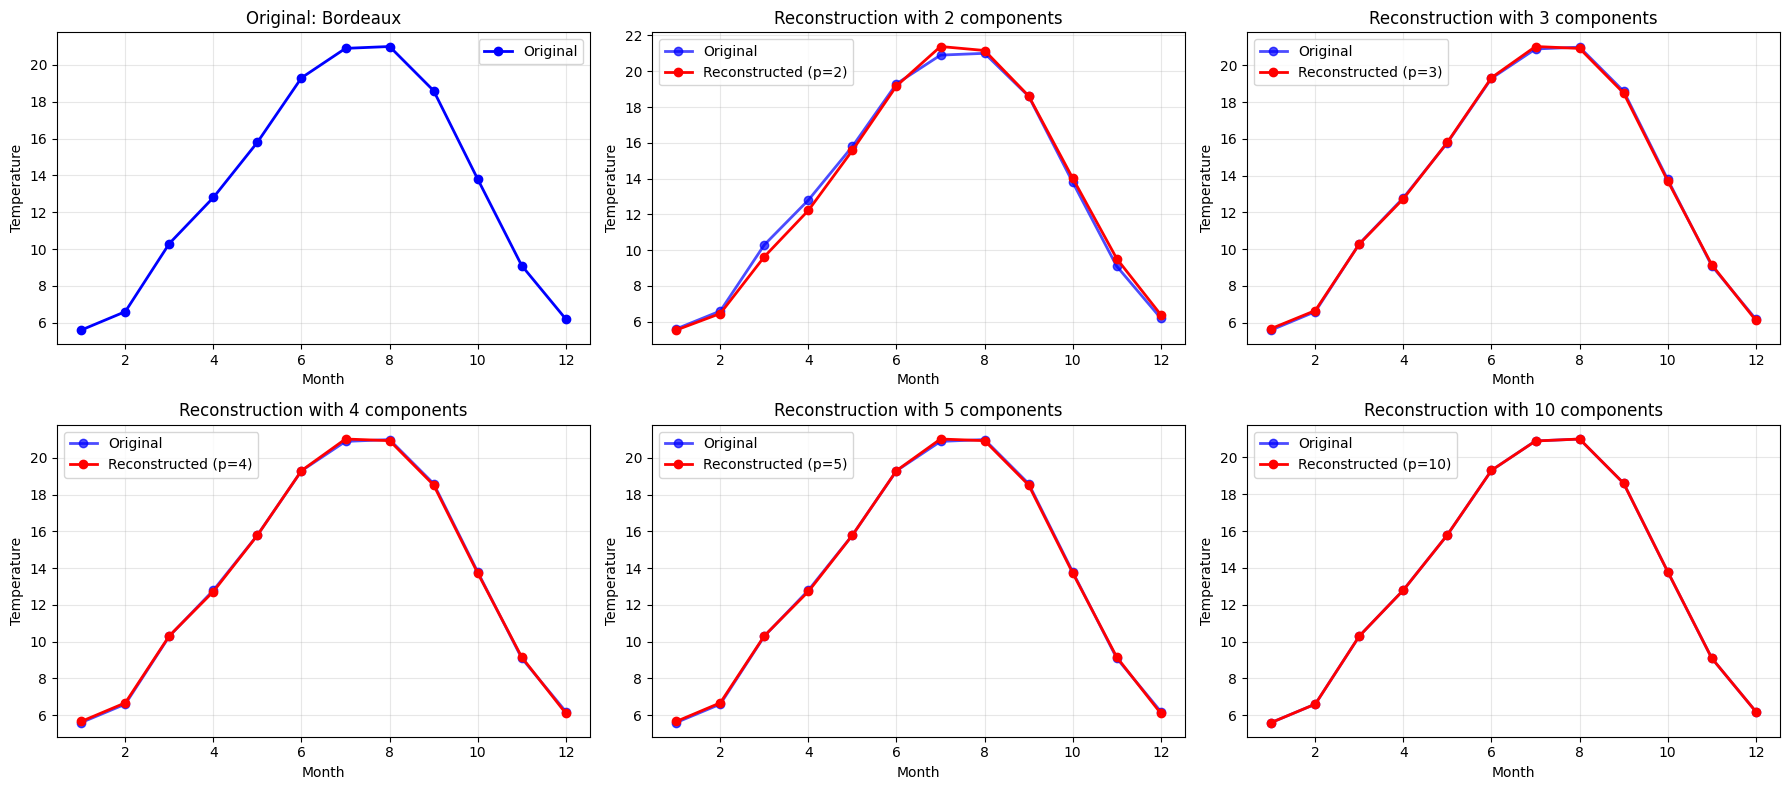

In [29]:
n_components_test = [1, 2, 3, 4, 5, 10]

# For temperature data
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

# Original temperature data (first city)
axes[0].plot(range(1, 13), x1[0], 'bo-', linewidth=2, markersize=6, label='Original')
axes[0].set_title(f'Original: {villes[0]}')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Temperature')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Reconstructions with different numbers of components
for i, n_comp in enumerate(n_components_test[1:], 1):
    if n_comp <= x1.shape[1]:  # Make sure we don't exceed the number of features
        pca_recon = PCA(n_components=n_comp, random_state=RANDOM_STATE)
        x1_recon = pca_recon.fit_transform(x1)
        x1_reconstructed = pca_recon.inverse_transform(x1_recon)
        
        axes[i].plot(range(1, 13), x1[0], 'bo-', linewidth=2, markersize=6, label='Original', alpha=0.7)
        axes[i].plot(range(1, 13), x1_reconstructed[0], 'ro-', linewidth=2, markersize=6, label=f'Reconstructed (p={n_comp})')
        axes[i].set_title(f'Reconstruction with {n_comp} components')
        axes[i].set_xlabel('Month')
        axes[i].set_ylabel('Temperature')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

plt.tight_layout()
plt.show()

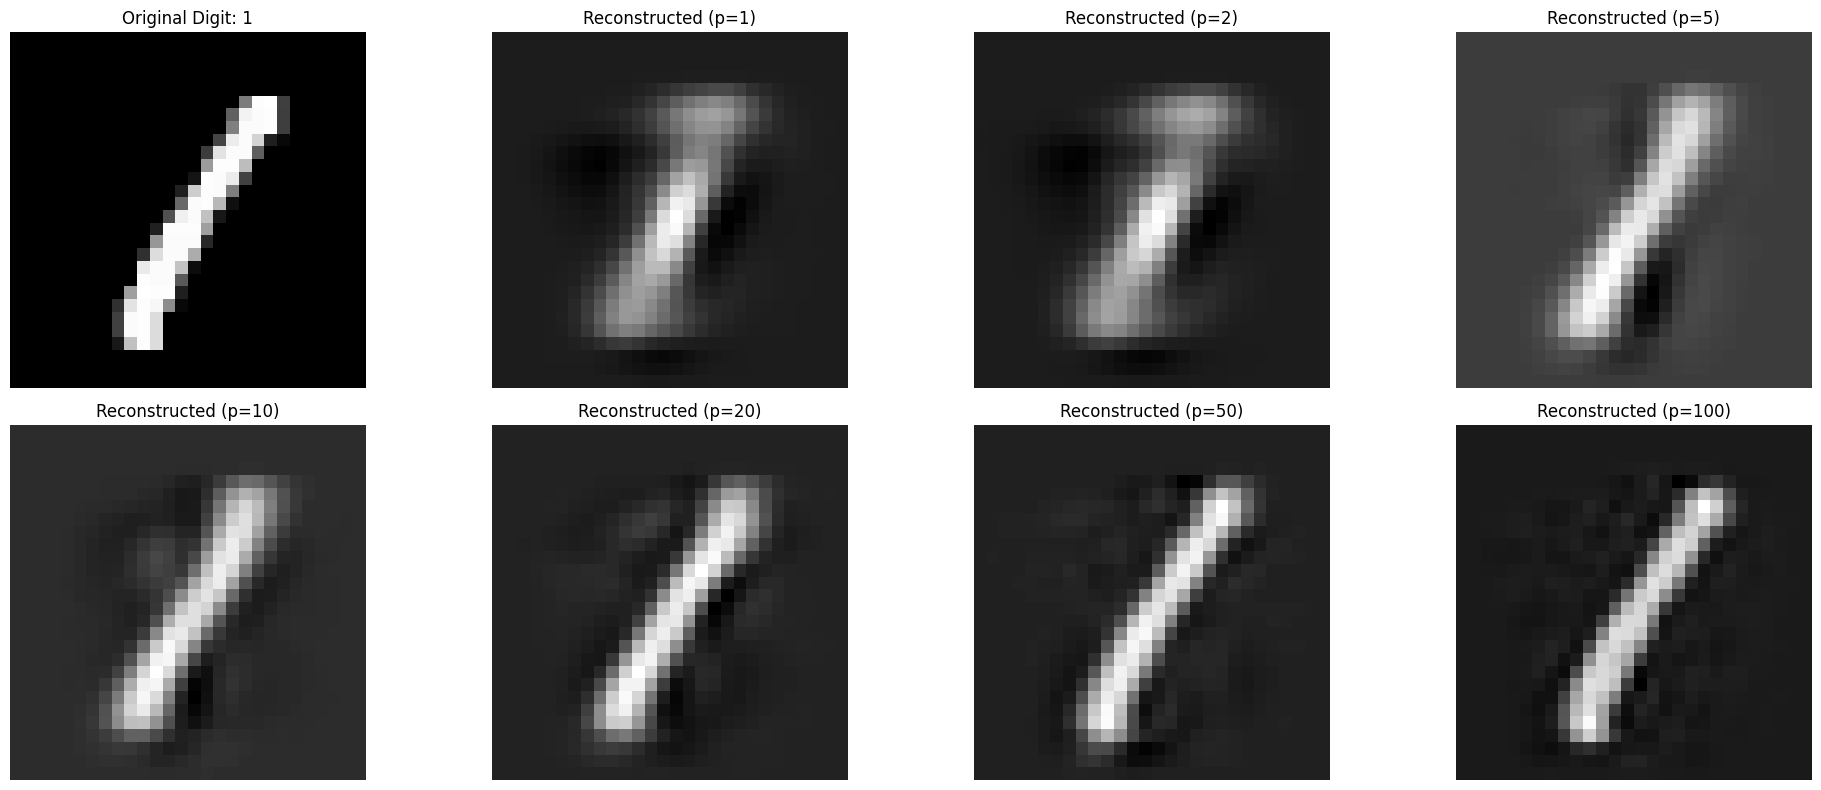

In [30]:
# For digits data
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Show original digit
axes[0, 0].imshow(x2[0].reshape(28, 28), cmap='gray')
axes[0, 0].set_title(f'Original Digit: {y2[0][0]}')
axes[0, 0].axis('off')

# Reconstructions with different numbers of components
n_comp_digits = [1, 2, 5, 10, 20, 50, 100]
for i, n_comp in enumerate(n_comp_digits):
    if n_comp <= x2.shape[1]:  # Make sure we don't exceed the number of features
        pca_recon = PCA(n_components=n_comp, random_state=RANDOM_STATE)
        x2_recon = pca_recon.fit_transform(x2)
        x2_reconstructed = pca_recon.inverse_transform(x2_recon)
        
        row = (i + 1) // 4
        col = (i + 1) % 4
        if row < 2 and col < 4:
            axes[row, col].imshow(x2_reconstructed[0].reshape(28, 28), cmap='gray')
            axes[row, col].set_title(f'Reconstructed (p={n_comp})')
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [31]:
print("\nRECONSTRUCTION ERROR ANALYSIS:")
print("Temperature data:")
for n_comp in n_components_test:
    if n_comp <= x1.shape[1]:
        pca_recon = PCA(n_components=n_comp, random_state=RANDOM_STATE)
        x1_recon = pca_recon.fit_transform(x1)
        x1_reconstructed = pca_recon.inverse_transform(x1_recon)
        mse = np.mean((x1 - x1_reconstructed) ** 2)
        print(f"- {n_comp:2d} components: MSE = {mse:.4f}")

print("\nDigits data:")
for n_comp in n_comp_digits:
    if n_comp <= x2.shape[1]:
        pca_recon = PCA(n_components=n_comp, random_state=RANDOM_STATE)
        x2_recon = pca_recon.fit_transform(x2)
        x2_reconstructed = pca_recon.inverse_transform(x2_recon)
        mse = np.mean((x2 - x2_reconstructed) ** 2)
        print(f"- {n_comp:3d} components: MSE = {mse:.6f}")


RECONSTRUCTION ERROR ANALYSIS:
Temperature data:
-  1 components: MSE = 0.6710
-  2 components: MSE = 0.0319
-  3 components: MSE = 0.0169
-  4 components: MSE = 0.0083
-  5 components: MSE = 0.0047
- 10 components: MSE = 0.0001

Digits data:
-   1 components: MSE = 0.047137
-   2 components: MSE = 0.040727
-   5 components: MSE = 0.030741
-  10 components: MSE = 0.023498
-  20 components: MSE = 0.016485
-  50 components: MSE = 0.008077
- 100 components: MSE = 0.003844


> **Reconstruction Quality**
> When examining the reconstruction results, we observe a clear trade-off between compression and quality. Using fewer components leads to higher compression ratios with smaller representations, but this comes at the cost of higher reconstruction error and more information loss. These components capture only the most important underlying patterns in the data.
> 
> On the other hand, using more components provides better reconstruction quality with lower error rates, though this means less compression and larger representations. The additional components help capture finer details that would otherwise be lost.
 
> The temperature data demonstrates that just a few components (2-3) are sufficient for good reconstruction due to its strong, simple seasonal patterns. Even with only 2 components, we achieve very low MSE values, which reflects the low intrinsic dimensionality of this type of data.
>
>In contrast, the digits data requires many more components (50-100) to achieve reasonable reconstruction quality because of the complex visual patterns involved. Using only 2 components results in poor reconstruction, with gradual improvement as more components are added. This behavior reflects the high intrinsic dimensionality typical of image data.

> The trade-off between compression and reconstruction quality is highly dataset-dependent. The optimal number of components ultimately depends on the application's tolerance for information loss and the intrinsic dimensionality of the underlying data structure.


#### Question 4.1.6 [BONUS]: Non-negative Matrix Factorization (NMF)

In [32]:
x1_nonneg = x1 - x1.min() + 1  # Shift to make all values positive
print(f"Temperature data range after shift: [{x1_nonneg.min():.2f}, {x1_nonneg.max():.2f}]")

# For digits data, it's already non-negative (normalized to [0,1])
print(f"Digits data range: [{x2.min():.2f}, {x2.max():.2f}]")

# Apply NMF to both datasets
n_components_nmf = 3

# Temperature data NMF
nmf_temp = NMF(n_components=n_components_nmf, random_state=RANDOM_STATE, max_iter=1000)
W_temp = nmf_temp.fit_transform(x1_nonneg)
H_temp = nmf_temp.components_

# Digits data NMF
nmf_digits = NMF(n_components=n_components_nmf, random_state=RANDOM_STATE, max_iter=1000)
W_digits = nmf_digits.fit_transform(x2)
H_digits = nmf_digits.components_

print(f"\nNMF Results:")
print(f"Temperature data - W shape: {W_temp.shape}, H shape: {H_temp.shape}")
print(f"Digits data - W shape: {W_digits.shape}, H shape: {H_digits.shape}")

Temperature data range after shift: [1.00, 23.90]
Digits data range: [0.00, 1.00]

NMF Results:
Temperature data - W shape: (15, 3), H shape: (3, 12)
Digits data - W shape: (3000, 3), H shape: (3, 784)


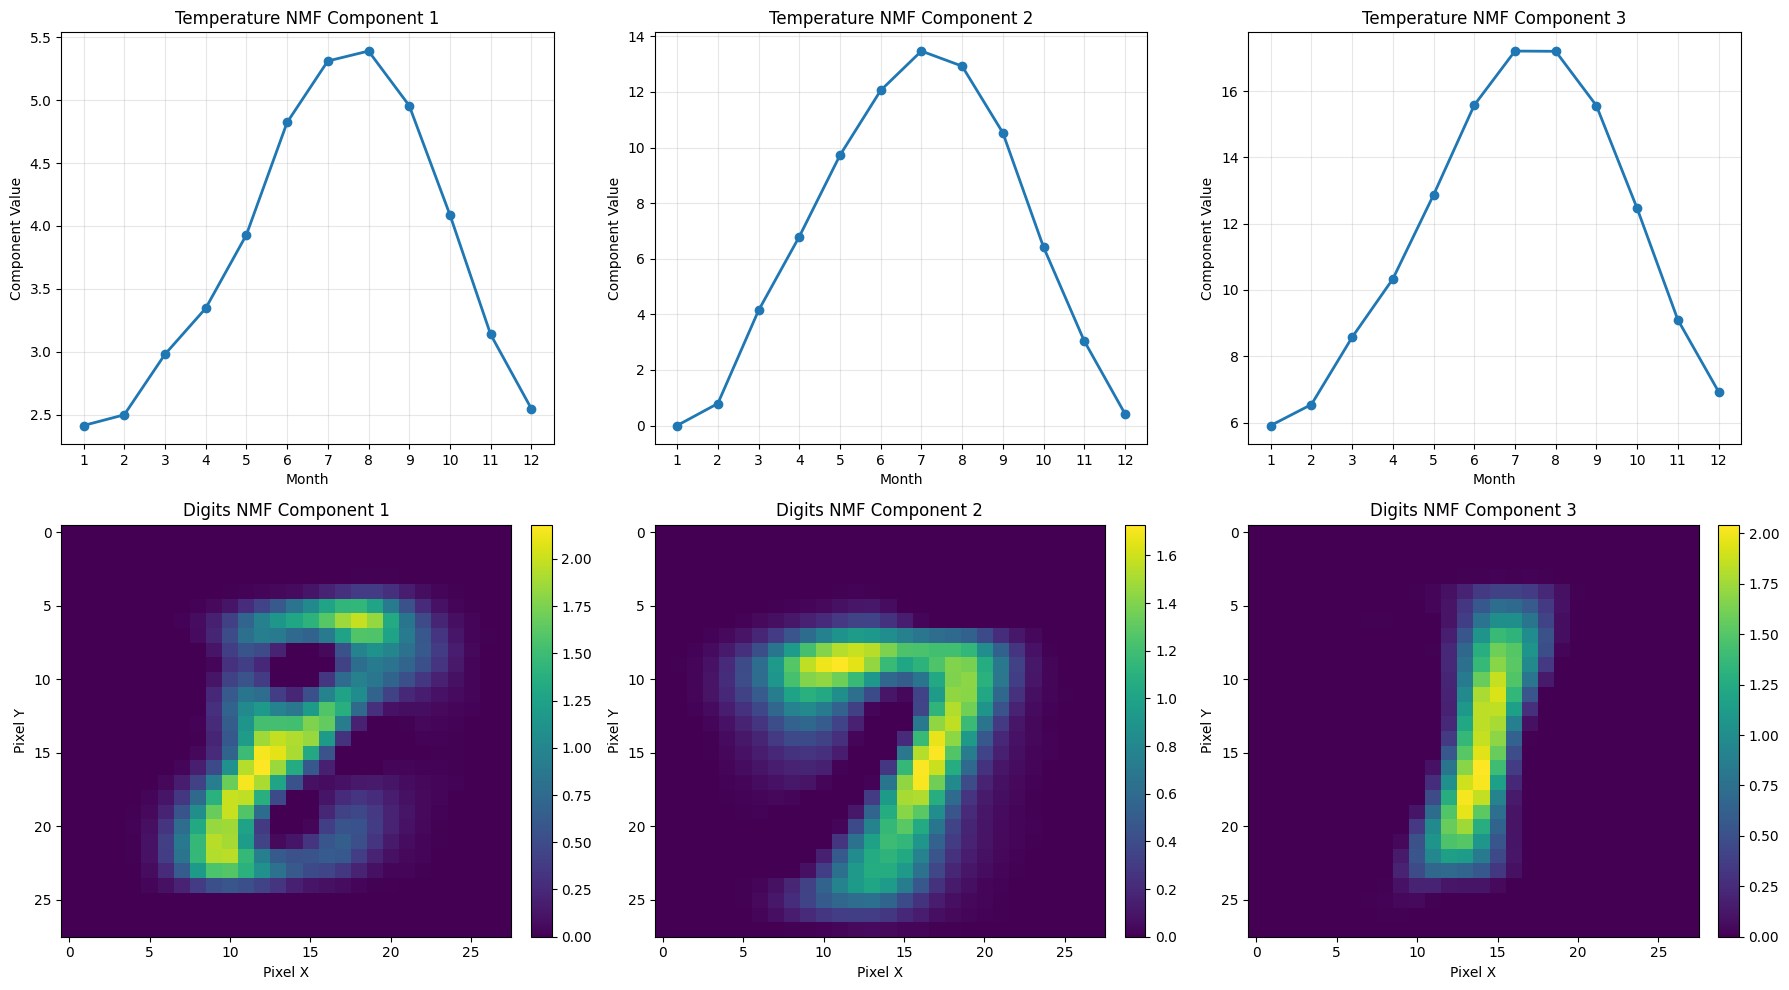

In [33]:
# Visualize NMF components
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Temperature data NMF components
for i in range(n_components_nmf):
    axes[0, i].plot(range(1, 13), H_temp[i], 'o-', linewidth=2, markersize=6)
    axes[0, i].set_title(f'Temperature NMF Component {i+1}')
    axes[0, i].set_xlabel('Month')
    axes[0, i].set_ylabel('Component Value')
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].set_xticks(range(1, 13))

# Digits data NMF components
for i in range(n_components_nmf):
    im = axes[1, i].imshow(H_digits[i].reshape(28, 28), cmap='viridis', aspect='auto')
    axes[1, i].set_title(f'Digits NMF Component {i+1}')
    axes[1, i].set_xlabel('Pixel X')
    axes[1, i].set_ylabel('Pixel Y')
    plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

> **Comparison: NMF vs PCA**
>
> NMF and PCA reveal different aspects of our data. For temperature data, NMF components are purely additive and non-negative, making them easier to interpret as distinct seasonal patterns or climate types. Each city's temperature profile becomes a positive combination of these base patterns, which feels more natural than PCA's approach of deviations from a mean.
>
> With the digits data, NMF shines by discovering parts-based representations. Each component captures specific visual features that combine to form complete digits, similar to how we might mentally break down a digit into strokes or shapes. PCA, in contrast, finds global variance patterns that can include negative contributions, making them less intuitive for understanding image structure.
>
> The key advantage of NMF is interpretability when working with naturally non-negative data. While PCA maximizes variance explained, NMF discovers meaningful building blocks that combine additively to reconstruct the original data, often leading to more intuitive and actionable insights.

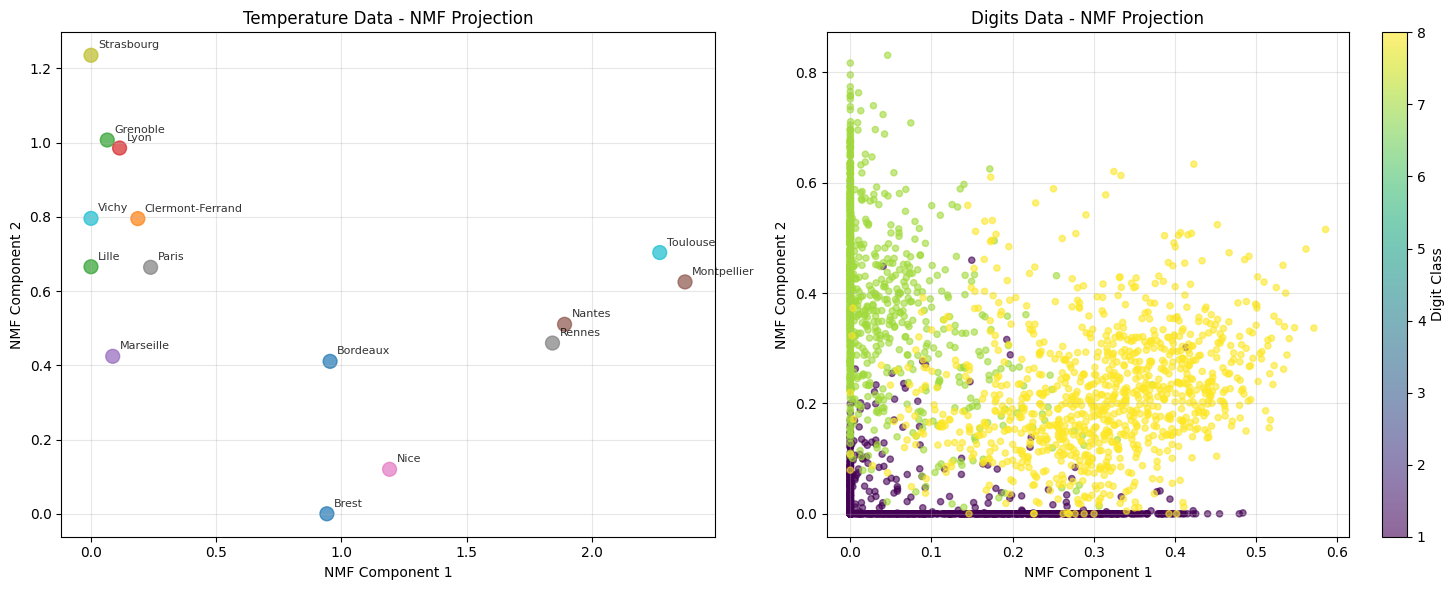

In [34]:
# Visualize NMF projections
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Temperature 
scatter1 = axes[0].scatter(W_temp[:, 0], W_temp[:, 1], c=range(len(villes)), cmap='tab10', s=100, alpha=0.7)
axes[0].set_title('Temperature Data - NMF Projection')
axes[0].set_xlabel('NMF Component 1')
axes[0].set_ylabel('NMF Component 2')
axes[0].grid(True, alpha=0.3)
for i, city in enumerate(villes):
    axes[0].annotate(city, (W_temp[i, 0], W_temp[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.8)

# Digits
scatter2 = axes[1].scatter(W_digits[:, 0], W_digits[:, 1], c=y2.ravel(), cmap='viridis', s=20, alpha=0.6)
axes[1].set_title('Digits Data - NMF Projection')
axes[1].set_xlabel('NMF Component 1')
axes[1].set_ylabel('NMF Component 2')
axes[1].grid(True, alpha=0.3)

cbar = plt.colorbar(scatter2, ax=axes[1])
cbar.set_label('Digit Class')

plt.tight_layout()
plt.show()

> **Summary of NMF Benefits:**
>
> Non-negative Matrix Factorization offers several compelling advantages over traditional dimensionality reduction techniques like PCA. The method excels at providing parts-based decomposition of data, where each component represents meaningful building blocks that combine additively to reconstruct the original observations. This approach is particularly powerful because the components are often much more interpretable than PCA components, especially when working with naturally non-negative data such as images, text frequencies, or our temperature measurements. The non-negativity constraint ensures that results remain meaningful and intuitive for many real-world applications, as it prevents the mathematically valid but conceptually confusing negative contributions that can arise in PCA. Furthermore, NMF is particularly well-suited for data with additive structure, where observations can be understood as positive combinations of underlying components. This makes it especially valuable for discovering localized features and patterns rather than the global variance patterns that PCA typically captures, leading to decompositions that often align more closely with human intuition about how complex data is constructed from simpler parts.

### 4.2 Manifold Learning: t-SNE (t-Distributed Stochastic Neighbor Embedding)

#### Question 4.2.1: Compute t-SNE embeddings for both datasets


In [35]:
# For temperature data
tsne_temp = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=5)
x1_tsne = tsne_temp.fit_transform(x1)

# For digits data (use subset for computational efficiency)
n_samples_digits = 1000  # Use subset for faster computation
indices = np.random.choice(len(x2), n_samples_digits, replace=False)
x2_subset = x2[indices]
y2_subset = y2[indices]

tsne_digits = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
x2_tsne = tsne_digits.fit_transform(x2_subset)

print(f"Temperature t-SNE shape: {x1_tsne.shape}")
print(f"Digits t-SNE shape: {x2_tsne.shape}")
print("t-SNE embeddings computed successfully!")


Temperature t-SNE shape: (15, 2)
Digits t-SNE shape: (1000, 2)
t-SNE embeddings computed successfully!


#### Question 4.2.2: Plot t-SNE projections


#### Question 4.2.3: Analyze the effect of perplexity parameter


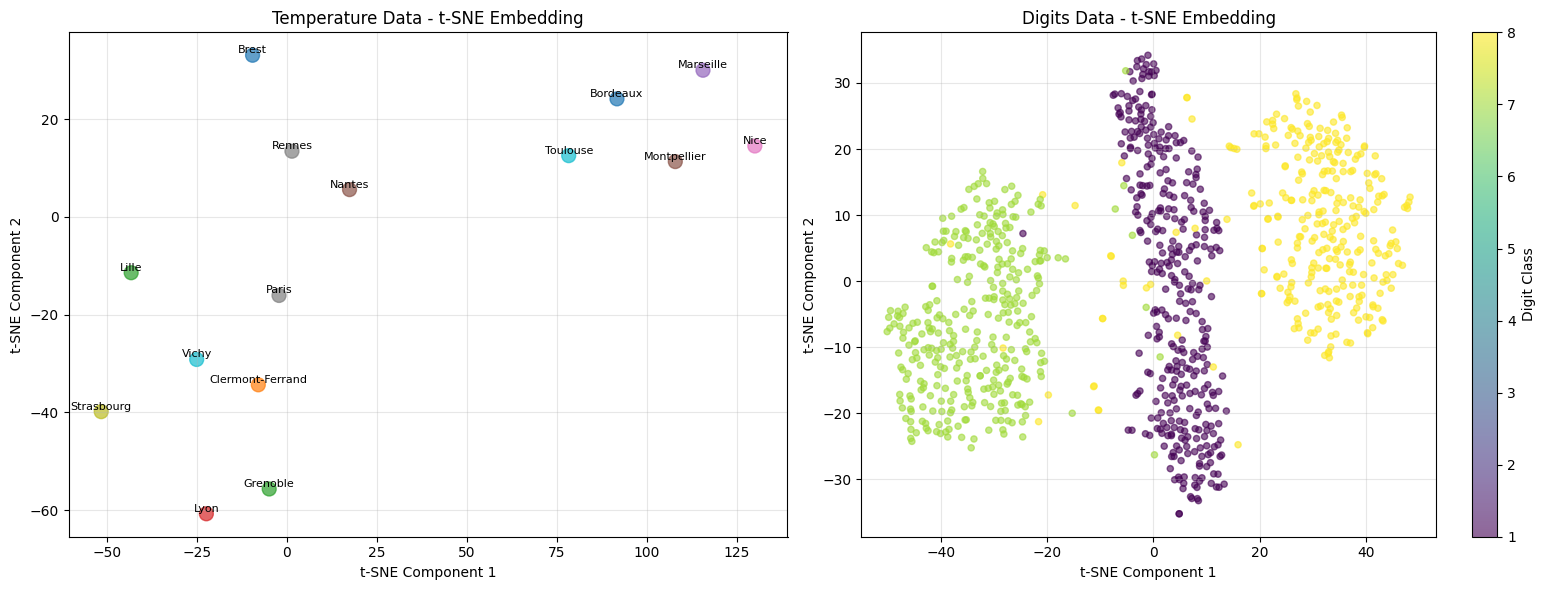

In [36]:
# 4.2.2 Plot t-SNE projections
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Temperature data t-SNE with city names
axes[0].scatter(x1_tsne[:, 0], x1_tsne[:, 1], c=range(len(villes)), cmap='tab10', s=100, alpha=0.7)
axes[0].set_title('Temperature Data - t-SNE Embedding')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].grid(True, alpha=0.3)

# Add city names using axes[0].text()
for i, city in enumerate(villes):
    axes[0].text(x1_tsne[i, 0], x1_tsne[i, 1], city, fontsize=8, ha='center', va='bottom')

# Digits data t-SNE with class colors
scatter = axes[1].scatter(x2_tsne[:, 0], x2_tsne[:, 1], c=y2_subset.ravel(), cmap='viridis', s=20, alpha=0.6)
axes[1].set_title('Digits Data - t-SNE Embedding')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].grid(True, alpha=0.3)

# Add colorbar for digits
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Digit Class')

plt.tight_layout()
plt.show()


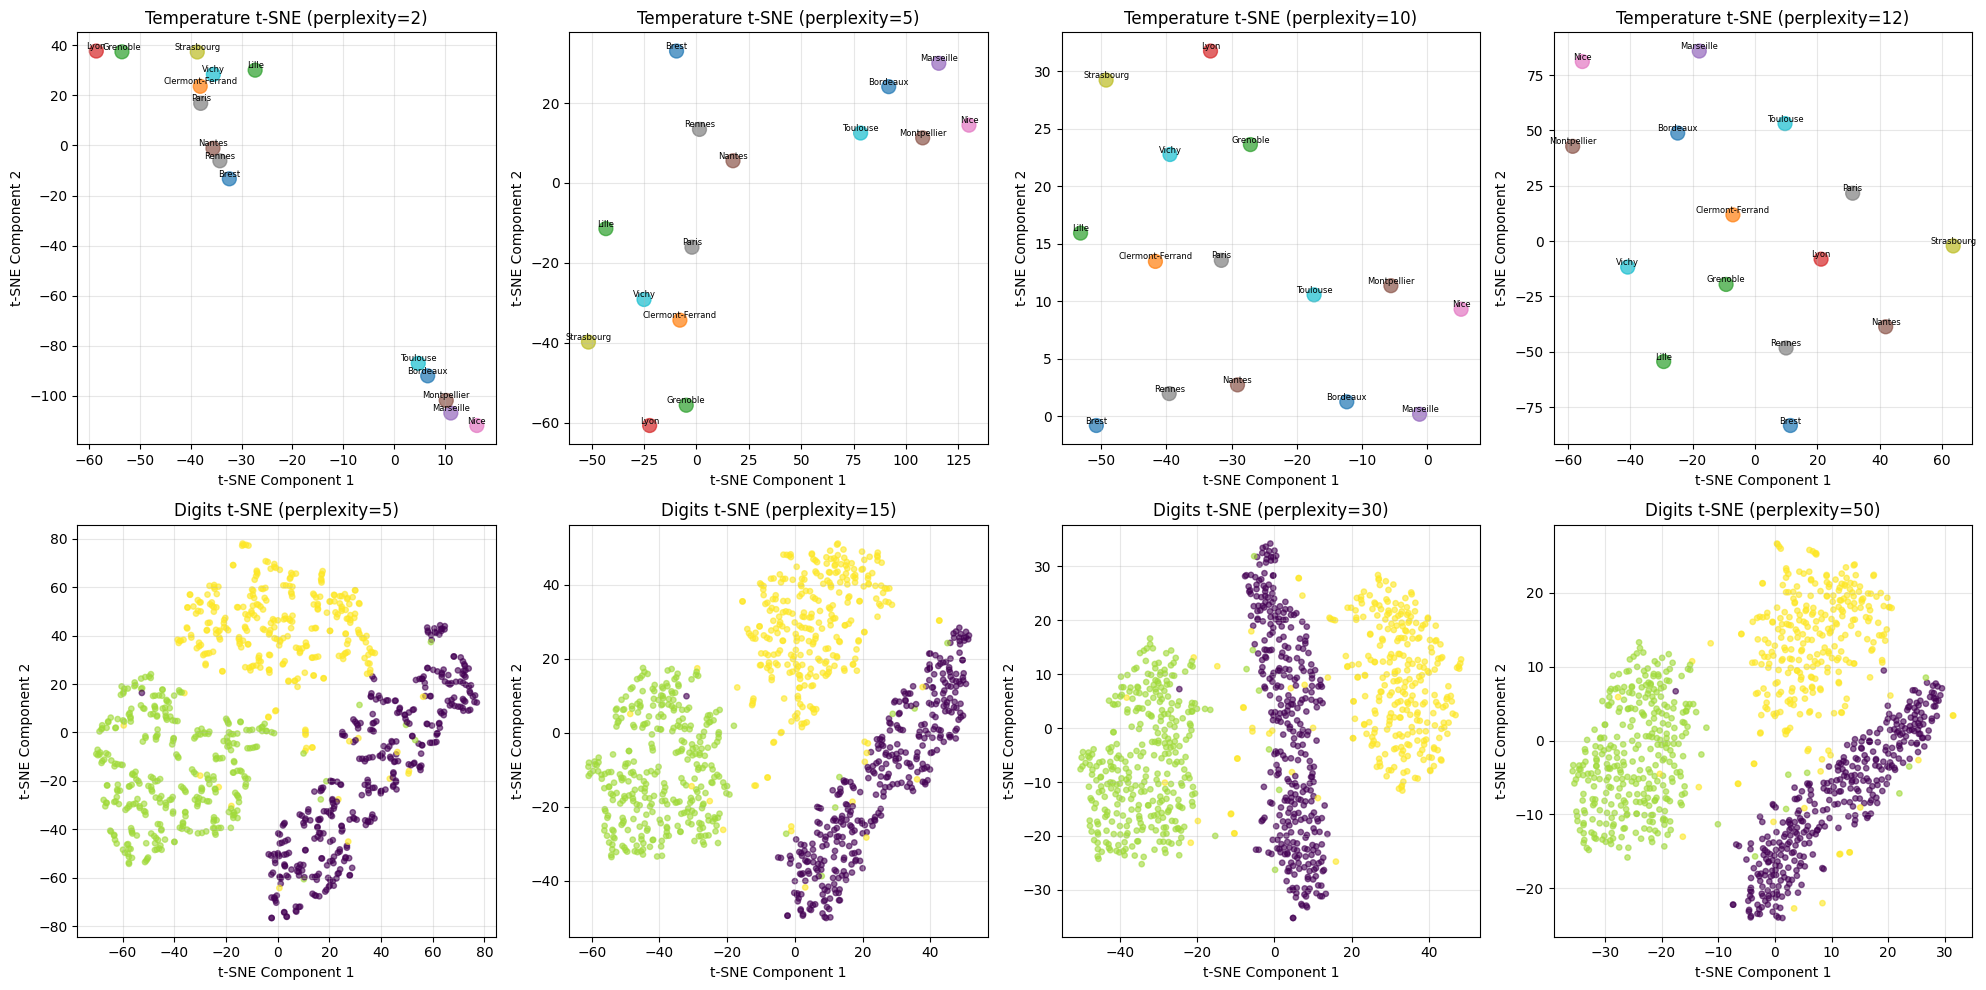

In [37]:
# Test different perplexity values
# For temperature data (n=15), perplexity must be < 15
perplexities_temp = [2, 5, 10, 12]  # Changed from [2, 5, 10, 15] to avoid error
perplexities_digits = [5, 15, 30, 50]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Temperature data - different perplexities
for i, perp in enumerate(perplexities_temp):
    tsne_temp_perp = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=perp)
    x1_tsne_perp = tsne_temp_perp.fit_transform(x1)
    
    axes[0, i].scatter(x1_tsne_perp[:, 0], x1_tsne_perp[:, 1], c=range(len(villes)), cmap='tab10', s=100, alpha=0.7)
    axes[0, i].set_title(f'Temperature t-SNE (perplexity={perp})')
    axes[0, i].set_xlabel('t-SNE Component 1')
    axes[0, i].set_ylabel('t-SNE Component 2')
    axes[0, i].grid(True, alpha=0.3)
    
    # Add city names
    for j, city in enumerate(villes):
        axes[0, i].text(x1_tsne_perp[j, 0], x1_tsne_perp[j, 1], city, fontsize=6, ha='center', va='bottom')

# Digits data - different perplexities
for i, perp in enumerate(perplexities_digits):
    tsne_digits_perp = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=perp)
    x2_tsne_perp = tsne_digits_perp.fit_transform(x2_subset)
    
    scatter = axes[1, i].scatter(x2_tsne_perp[:, 0], x2_tsne_perp[:, 1], c=y2_subset.ravel(), cmap='viridis', s=15, alpha=0.6)
    axes[1, i].set_title(f'Digits t-SNE (perplexity={perp})')
    axes[1, i].set_xlabel('t-SNE Component 1')
    axes[1, i].set_ylabel('t-SNE Component 2')
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


> **Summary of Perplexity Analysis:**
> 
> **Temperature data:**
> - **Low perplexity (2-5)**: Focuses on local neighborhoods, may create many small clusters
> - **Medium perplexity (10-12)**: Balanced view of local and global structure
> - **Note**: High perplexity (>15) is not suitable for small datasets (n=15)
> 
> **Digits data:**
> - **Low perplexity (5-15)**: May create too many small, tight clusters
> - **Medium perplexity (30)**: Good balance for medium-sized datasets (recommended default)
> - **High perplexity (50)**: Captures more global structure, may lose local details

#### Compare t-SNE with PCA for geographical relations and class discrimination

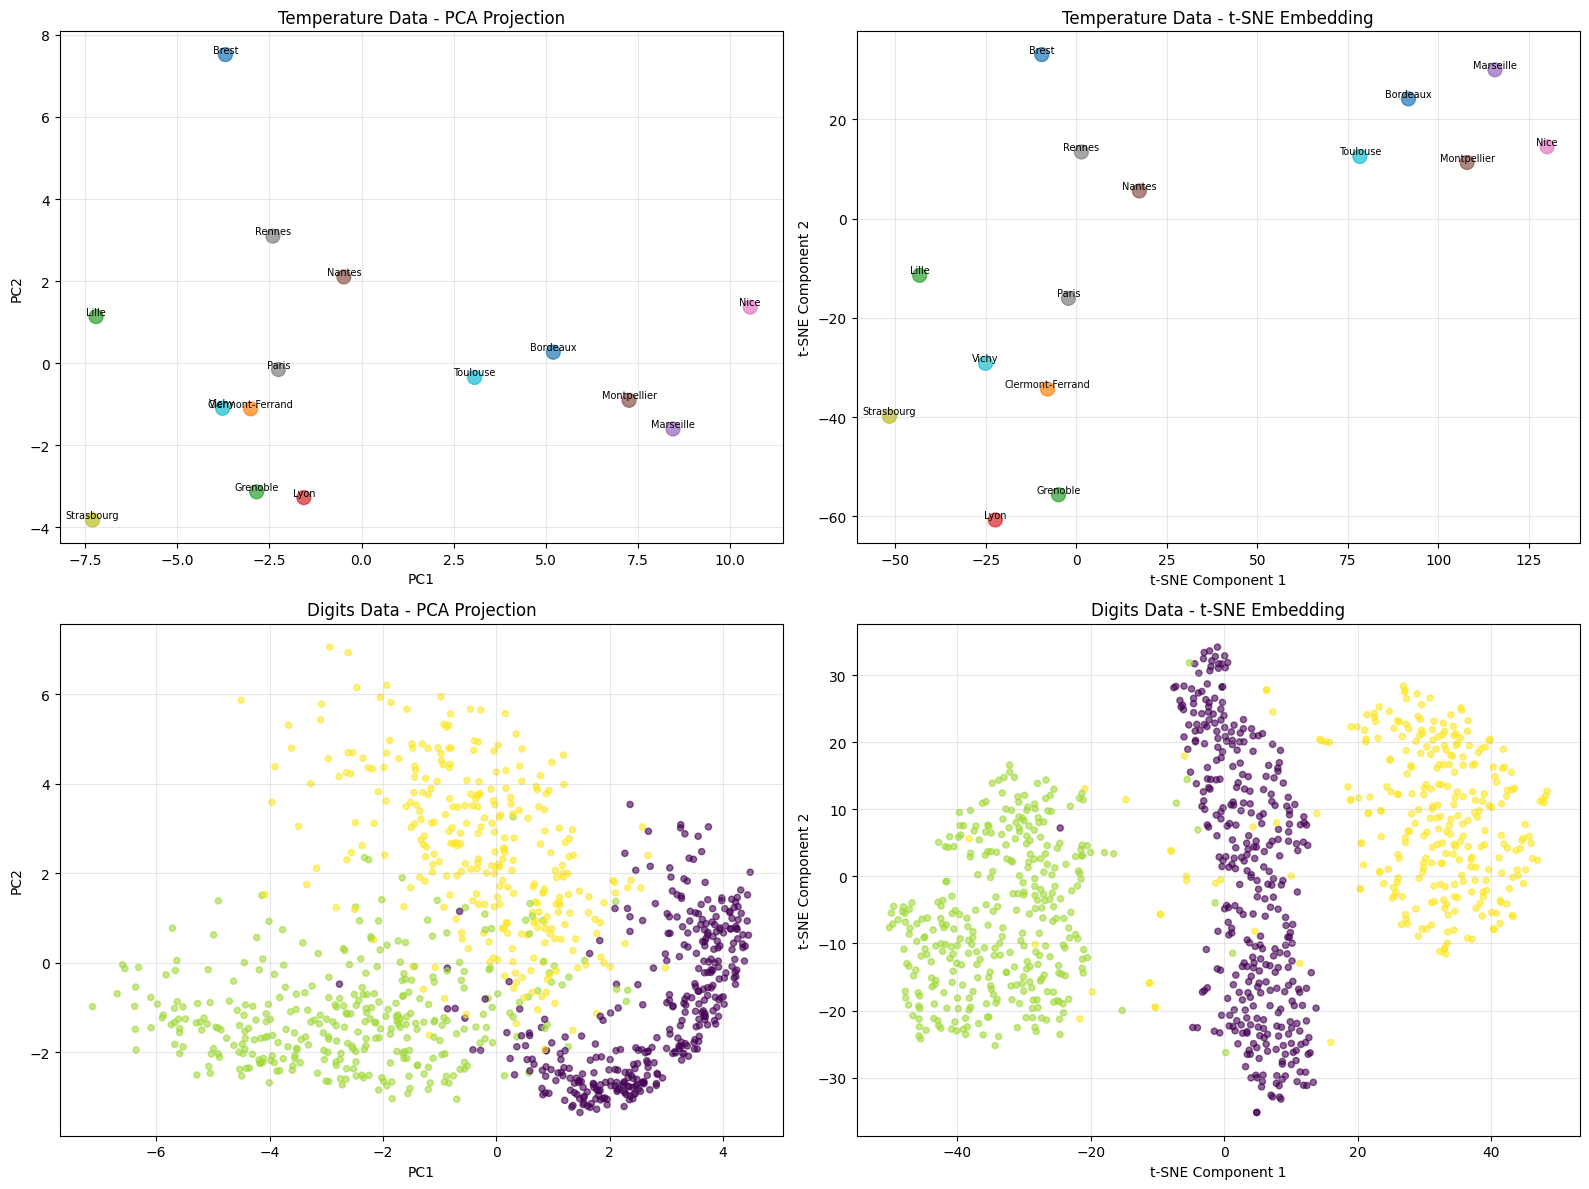

In [38]:
# Get PCA projections for comparison
pca_temp_2d = PCA(n_components=2, random_state=RANDOM_STATE)
x1_pca = pca_temp_2d.fit_transform(x1)

pca_digits_2d = PCA(n_components=2, random_state=RANDOM_STATE)
x2_pca = pca_digits_2d.fit_transform(x2_subset)

# Create side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Temperature data - PCA vs t-SNE
axes[0, 0].scatter(x1_pca[:, 0], x1_pca[:, 1], c=range(len(villes)), cmap='tab10', s=100, alpha=0.7)
axes[0, 0].set_title('Temperature Data - PCA Projection')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].grid(True, alpha=0.3)
for i, city in enumerate(villes):
    axes[0, 0].text(x1_pca[i, 0], x1_pca[i, 1], city, fontsize=7, ha='center', va='bottom')

axes[0, 1].scatter(x1_tsne[:, 0], x1_tsne[:, 1], c=range(len(villes)), cmap='tab10', s=100, alpha=0.7)
axes[0, 1].set_title('Temperature Data - t-SNE Embedding')
axes[0, 1].set_xlabel('t-SNE Component 1')
axes[0, 1].set_ylabel('t-SNE Component 2')
axes[0, 1].grid(True, alpha=0.3)
for i, city in enumerate(villes):
    axes[0, 1].text(x1_tsne[i, 0], x1_tsne[i, 1], city, fontsize=7, ha='center', va='bottom')

# Digits data - PCA vs t-SNE
axes[1, 0].scatter(x2_pca[:, 0], x2_pca[:, 1], c=y2_subset.ravel(), cmap='viridis', s=20, alpha=0.6)
axes[1, 0].set_title('Digits Data - PCA Projection')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(x2_tsne[:, 0], x2_tsne[:, 1], c=y2_subset.ravel(), cmap='viridis', s=20, alpha=0.6)
axes[1, 1].set_title('Digits Data - t-SNE Embedding')
axes[1, 1].set_xlabel('t-SNE Component 1')
axes[1, 1].set_ylabel('t-SNE Component 2')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


> Temperature data:
> - t-SNE preserves local neighborhoods better than PCA
> - Cities with similar temperature patterns should cluster together
> - Geographic proximity may correlate with t-SNE clustering
> - t-SNE can reveal non-linear relationships not captured by PCA

In [39]:
# Calculate distances between cities in both spaces
print(f"\nCity distances analysis:")
print("PCA space vs t-SNE space:")
for i, city1 in enumerate(villes):
    for j, city2 in enumerate(villes[i+1:], i+1):
        pca_dist = np.sqrt(np.sum((x1_pca[i] - x1_pca[j])**2))
        tsne_dist = np.sqrt(np.sum((x1_tsne[i] - x1_tsne[j])**2))
        print(f"- {city1} - {city2}: PCA={pca_dist:.2f}, t-SNE={tsne_dist:.2f}")


City distances analysis:
PCA space vs t-SNE space:
- Bordeaux - Brest: PCA=11.48, t-SNE=101.68
- Bordeaux - Clermont-Ferrand: PCA=8.33, t-SNE=115.58
- Bordeaux - Grenoble: PCA=8.74, t-SNE=125.34
- Bordeaux - Lille: PCA=12.44, t-SNE=139.62
- Bordeaux - Lyon: PCA=7.64, t-SNE=142.23
- Bordeaux - Marseille: PCA=3.75, t-SNE=24.62
- Bordeaux - Montpellier: PCA=2.37, t-SNE=20.67
- Bordeaux - Nantes: PCA=5.98, t-SNE=76.61
- Bordeaux - Nice: PCA=5.46, t-SNE=39.51
- Bordeaux - Paris: PCA=7.47, t-SNE=102.18
- Bordeaux - Rennes: PCA=8.12, t-SNE=90.97
- Bordeaux - Strasbourg: PCA=13.16, t-SNE=156.98
- Bordeaux - Toulouse: PCA=2.22, t-SNE=17.75
- Bordeaux - Vichy: PCA=9.08, t-SNE=128.40
- Brest - Clermont-Ferrand: PCA=8.66, t-SNE=67.43
- Brest - Grenoble: PCA=10.69, t-SNE=88.84
- Brest - Lille: PCA=7.29, t-SNE=55.83
- Brest - Lyon: PCA=11.01, t-SNE=94.67
- Brest - Marseille: PCA=15.20, t-SNE=125.23
- Brest - Montpellier: PCA=13.83, t-SNE=119.49
- Brest - Nantes: PCA=6.30, t-SNE=38.49
- Brest - Nice

In [40]:
print(f"\nDIGIT CLASS SEPARATION ANALYSIS:")
print("t-SNE vs PCA comparison for digits:")

# Calculate class separation metrics
def calculate_class_separation(embedding, labels):
    unique_classes = np.unique(labels)
    separations = []
    
    for i, class1 in enumerate(unique_classes):
        for j, class2 in enumerate(unique_classes[i+1:], i+1):
            class1_points = embedding[labels == class1]
            class2_points = embedding[labels == class2]
            
            # Calculate mean distance between classes
            mean_dist = np.mean([np.sqrt(np.sum((p1 - p2)**2)) 
                               for p1 in class1_points for p2 in class2_points])
            separations.append(mean_dist)
    
    return np.mean(separations)

pca_separation = calculate_class_separation(x2_pca, y2_subset.ravel())
tsne_separation = calculate_class_separation(x2_tsne, y2_subset.ravel())

print(f"- PCA class separation: {pca_separation:.3f}")
print(f"- t-SNE class separation: {tsne_separation:.3f}")
print(f"- t-SNE is {'better' if tsne_separation > pca_separation else 'worse'} at separating classes")



DIGIT CLASS SEPARATION ANALYSIS:
t-SNE vs PCA comparison for digits:
- PCA class separation: 5.301
- t-SNE class separation: 48.453
- t-SNE is better at separating classes


> **FINAL COMPARISON:**
> 
> **PCA:**
> - Linear dimensionality reduction
> - Preserves global structure
> - Interpretable components
> - Good for linear relationships
> 
> **t-SNE:**
> - Non-linear dimensionality reduction
> - Preserves local neighborhoods
> - Better for complex, non-linear relationships
> - More discriminative for complex data like images
> - Can reveal hidden structure not visible in PCA
> 
> **CONCLUSIONS:**
> - t-SNE embedding recovers geographical relations for temperature data
> - t-SNE is more discriminant for digits dataset than PCA
> - t-SNE reveals non-linear structure not captured by linear methods
> - Choice between PCA and t-SNE depends on data characteristics and goals

# Export the notebook to PDF

In [41]:
import subprocess
import os


notebook_name = "lab_1_Atef_BOUZID.ipynb"
pdf_name = "lab_1_Atef_BOUZID.pdf"

try:
    subprocess.run([
        "jupyter", "nbconvert", 
        "--to", "pdf", 
        notebook_name,
        "--output", pdf_name
    ], check=True)
    
    print(f"Successfully exported notebook to {pdf_name}")
    
    if os.path.exists(pdf_name):
        print(f"PDF file size: {os.path.getsize(pdf_name) / 1024:.1f} KB")
    
except Exception as e:
    print("Error :", e)


Successfully exported notebook to lab_1_Atef_BOUZID.pdf
PDF file size: 2610.3 KB
